In [122]:
from jfit import *
from jplot import *
from jFermi2.ImgAnalysis.SingleSiteAnalysis import *
import glob

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 80

In [123]:
########################
### Helper Functions ###
########################
def load_imgs(run_name):
    # Load images
    img1 = np.loadtxt(os.path.join('Data', run_name+'_binned1.txt'))
    img2 = np.loadtxt(os.path.join('Data', run_name+'_binned2.txt'))
    # Find COM and shift the images
    img = img1+img2
    _x0, _y0 = get_com(img)
    _dim_x, _dim_y = img.shape
    img1_s = scipy.ndimage.shift(img1, (-(_x0-_dim_x/2.), -(_y0-_dim_y/2.)), order=0, mode='constant', cval=0)
    img2_s = scipy.ndimage.shift(img2, (-(_x0-_dim_x/2.), -(_y0-_dim_y/2.)), order=0, mode='constant', cval=0)
    return img1_s, img2_s

def show_stats(df):
    def plot_hist(df, ax, variables, xrange, resolution):
        for ii, _var in enumerate(variables):
            x0, x1 = xrange
            nx = int((x1-x0)/resolution)
            *_, = ax.hist(df[_var], bins=np.linspace(x0, x1, nx), rwidth=0.5, alpha=0.75, align='left')
        setlabels(ax, [', '.join(variables), ''])
        
    fig, axs = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
    axs = axs.ravel()
    plot_hist(df, axs[0], ['com_x', 'com_y'], xrange=[20, 40], resolution=1)
    plot_hist(df, axs[1], ['N'], xrange=[0,1200], resolution=10)
    plot_hist(df, axs[2], ['N2'], xrange=[0, 800], resolution=5)
    plot_hist(df, axs[3], ['imbal_corr'], xrange=[-0.6, 0.6], resolution=0.025)
    plot_hist(df, axs[4], ['imbal_s_corr'], xrange=[-0.6, 0.6], resolution=0.025)
    plot_hist(df, axs[5], ['PSF_width_1', 'PSF_width_2'], xrange=[0, 7], resolution=0.25)
    plot_hist(df, axs[6], ['fluor_pk_1', 'fluor_pk_2'], xrange=[400, 1000], resolution=25)
    plot_hist(df, axs[7], ['N1_loss_bri', 'N2_loss_bri'], xrange=[0, 0.3], resolution=0.01)
    plot_hist(df, axs[8], ['N1_hop_bri', 'N2_hop_bri'], xrange=[0, 0.1], resolution=0.005)
    plot_hist(df, axs[9], ['frac_misid_1', 'frac_misid_2'], xrange=[0, 0.3], resolution=0.005)
    plt.show()
    
def load_all_imgs(df):
    imgs = []
    for ii, _id in enumerate(df.index):
        img_up, img_dn = load_imgs(df.loc[_id, 'Run Name'][:-5])
        img_h, img_s, img_d, img_n = get_n_img(img_up+img_dn, [0, 1, 2])
        img_s_up = img_up-img_d
        img_s_dn = img_dn-img_d
        
        # Get isolated unpaired spins as well
        dispToClear = [[0,1]] # Remove all elements of first array that have an element in second array at this displacement, or symmetries 
        img_s_up_isol = clear_ImgOfComparedDisplacements(img_s_up, img_s_dn, dispToClear)
        img_s_dn_isol = clear_ImgOfComparedDisplacements(img_s_dn, img_s_up, dispToClear)
        
        # Polarization
        img_p = img_up-img_dn
        img_p_isol = img_s_up_isol-img_s_dn_isol
        
        # Repulsive spin analog
        img_p_dh = img_d-img_h
        
        imgs.append([img_up, img_dn, img_h, img_s, img_d, img_n, img_s_up, img_s_dn, img_s_up_isol, img_s_dn_isol, img_p, img_p_isol,img_p_dh])
    imgs = dict(zip(['up', 'dn', 'h', 's', 'd', 'n', 's_up', 's_dn', 's_up_isol', 's_dn_isol', 'p', 'p_isol','p_dh'], np.array(imgs).transpose((1, 0, 2, 3))))
    return imgs

def clear_ImgOfComparedDisplacements(imgSeed, imgComp, dispToCheck):
    # Takes imgSeed, and removes all elements that have nonzero values of imgComp at dispToCheck displacements, taking into account symmetries of dispToCheck
    # Ex. dispToCheck = [[0,1], [1,1]]
    permArr = get_symmetry_permutation_unique(dispToCheck) 
    for _p in permArr:
        imgSeed = imgSeed*(1-scipy.ndimage.shift(imgComp, (_p[0],_p[1]), order=0, mode='constant', cval=0))
    return imgSeed

def extract_binned_vals_in_img(_chop_mask, _img): # Takes value from only area in chop mask 
    _, _, binned_val, binned_err = bin_average(_chop_mask, _img, bin_num=2)
    return binned_val[-1], binned_err[-1] 

def extract_binned_vals_in_d_arr(_chop_mask, _img_arr, _d_arr):
    _arr_vals, _arr_errs = [], []
    for _id, _d in enumerate(_d_arr):
        _img_val, _img_err = extract_binned_vals_in_img(_chop_mask, _img_arr[_id])
        _arr_vals.append(_img_val)
        _arr_errs.append(_img_err)
    return np.array(_arr_vals), np.array(_arr_errs)

def gen_chop_mask_radial_arr(rMax,numRadBins, _img):
    # Generates an array of chop mask images which are equal area out to rMax
    rSqArr = np.linspace(0, rMax**2, numRadBins+1, endpoint=True)
    rArr = np.sqrt(rSqArr)
    drArr = np.diff(rArr)
    
    chop_mask_arr = []
    for _ir, dr in enumerate(drArr):
        r_min = rArr[_ir]; r_max = rArr[_ir+1]

        # Build chopping mask
        _dim1, _dim2 = _img.shape
        _dim1c = np.round(_dim1/2).astype(int); _dim2c = np.round(_dim2/2).astype(int)
        chop_mask_outer = np.fromfunction(lambda x, y: np.where(np.sqrt((x-_dim1c)**2+(y-_dim2c)**2)<=r_max, 1, 0), (_dim1, _dim2))
        chop_mask_arr.append(np.fromfunction(lambda x, y: np.where(np.sqrt((x-_dim1c)**2+(y-_dim2c)**2)>=r_min, chop_mask_outer, 0), (_dim1, _dim2)))
    return np.asarray(chop_mask_arr)

# Generate a function to cut out images that are at a specific polarization from the imgs array
def selectImgs(imgs, _dfSelect, selectVarName, selectVals):
    selectLocs = np.intersect1d(np.where(np.array(_dfSelect[selectVarName]).astype(float)>selectVals[0]),np.where(np.array(_dfSelect[selectVarName]).astype(float)<selectVals[1]))
    newValues = np.array([np.array(list(imgs.values())[keyInd][selectLocs]) for keyInd in range(len(list(imgs.keys())))])
    return dict(zip(list(imgs.keys()),newValues))

In [124]:
# 2 Point Correlator functions

def get_symmetry_permutation(d):
    _d = d
    rx = [[-1, 0], [0, 1]]
    rx = [[1, 0], [0, -1]]
    c4 = [[0, -1], [1, 0]]
    for ii in range(2):
        _d = np.dot(rx, _d)
        for jj in range(4):
            yield list(_d)
            _d  = np.dot(c4, _d)
def get_symmetry_permutation_unique(dispArr):
    # ie [[0,1]] generates all rotated combos of [0,1] just once 
    # Ex. dispToCheck = [[0,1], [1,1]]
    permArrNonUniqueFlat = []
    for _d in dispArr:
        for _dSym in list(get_symmetry_permutation(_d)):
            permArrNonUniqueFlat.append(_dSym)
    return np.unique(permArrNonUniqueFlat, axis = 0)

def get_c_ImgArrs(arrs, d_max):
    # Generates an array of 2D images with the connected correlator at displacement d at each point in the image, for each d 
    img_dim = np.array(arrs).shape[2:]    
    _ds, _c_arrs = [], []
    for ii in range(d_max+1):
        for jj in range(ii+1):
            _c, *_,  = get_cij(*arrs, [ii, jj])
            _c_arrs.append(_c)
            _ds.append([ii, jj])
    _rs = [np.sqrt(_d[0]**2+_d[1]**2) for _d in _ds]
    return _ds,_rs,_c_arrs

def build_c_sum_from_c(_d_arr, _r_arr, _c_arr):
    # Generates an array of 2D images 
    # Returns sum of c values at radius less than or equal to d location, taking into account symmetry/degeneracy of rotation
    _deg = [len(np.unique(list(get_symmetry_permutation(_d)), axis=0)) for _d in _d_arr]
    _c_arr_degCorr = np.array([_c_arr[ii]*_deg[ii] for ii in range(len(_deg))])
    _c_sum_arr = np.array([np.sum(_c_arr_degCorr[np.where(_r_arr<=_r)], axis=0) for _r in _r_arr])
    return _c_sum_arr

def build_cmat(d, c):
    # Takes a list of displacements in 2D and correlator values and generates a 2D matrix 
    d_max = int(np.max(d))
    cmat = np.zeros((2*d_max+1, 2*d_max+1))
    for ii, _d in enumerate(d):
        for _d_sym in get_symmetry_permutation(_d):
            _i, _j  = _d_sym
            cmat[_i+d_max, _j+d_max] = c[ii]
    return cmat

In [125]:
# 3 Point Correlator functions 

def get_nijk_ImgArrs(arr0, arr1, arr2, d1to2, d_max):
    # Generates an array of 2D images with the expectation value of nijk
    # d refers to displacement of arr1 from arr0
    # d1to2 refers to displacement of arr2 from arr1
    
    img_dim = np.array(arr0).shape[1:]    
    _ds, _nijk_arrs, _nij_arrs, _nik_arrs, _njk_arrs, _ni_arrs, _nj_arrs, _nk_arrs = [], [], [], [], [], [], [], []
 
    for ii in range(-d_max,d_max+1):
        for jj in range(-d_max,d_max+1):
            _nijk, _nij, _nik, _njk, _ni, _nj, _nk = np.average([get_nijk_SymAvg(arr0[imgInd], arr1[imgInd], arr2[imgInd],  [ii, jj], d1to2) 
                                                                 for imgInd in range(len(arr0))], axis=0)
            _nijk_arrs.append(_nijk)
            _nij_arrs.append(_nij)
            _nik_arrs.append(_nik)
            _njk_arrs.append(_njk)
            _ni_arrs.append(_ni)
            _nj_arrs.append(_nj)
            _nk_arrs.append(_nk)
            _ds.append([ii, jj])
    _rs = [np.sqrt(_d[0]**2+_d[1]**2) for _d in _ds]
    return _ds, _rs, _nijk_arrs, _nij_arrs, _nik_arrs, _njk_arrs, _ni_arrs, _nj_arrs, _nk_arrs

def get_nijk(_img0,_img1,_img2,_d0to1,_d1to2):
    _img1_shift = scipy.ndimage.shift(_img1, (_d0to1[0], _d0to1[1]), order=0, mode='constant', cval=scipy.stats.mode(np.array(_img1).flatten())[0])
    _img2_shift = scipy.ndimage.shift(_img2, (_d0to1[0]+_d1to2[0], _d0to1[1]+_d1to2[1]), order=0, mode='constant', cval=scipy.stats.mode(np.array(_img2).flatten())[0])
    [_nijk, _nij, _nik, _njk, 
     _ni, _nj, _nk] = [np.multiply(_img0,np.multiply(_img1_shift, _img2_shift)), 
                       np.multiply(_img0,_img1_shift), 
                       np.multiply(_img0,_img2_shift), 
                       np.multiply(_img1_shift,_img2_shift), 
                       _img0, _img1_shift,_img2_shift]
    return _nijk, _nij, _nik, _njk, _ni, _nj, _nk

def get_nijk_SymAvg(_img0,_img1,_img2,_d0to1,_d1to2):
    # How to do symmetry averaging on 3 point conditional? We want to keep the relative angles of the various things fixed. 
        # So we want to reflect d1to2 about d0to1, and then we also want to rotate d0to1 around the origin in symmetry permutations while keeping the angle fixed between the two displacements. 
    # Get two permutation lists that are locked in phase to give all the symmetry permutations 
    d0to1List = np.array(list(get_symmetry_permutation(_d0to1)))
    d0to2List = np.array(list(get_symmetry_permutation(np.array(_d0to1)+np.array(_d1to2))))
    d1to2List = d0to2List - d0to1List
    [_nijk_SymAvg, _nij_SymAvg, _nik_SymAvg, _njk_SymAvg, 
     _ni_SymAvg, _nj_SymAvg, _nk_SymAvg]  = np.average([get_nijk(_img0,_img1,_img2, d0to1List[ii], d1to2List[ii]) for ii in range(len(d0to1List))], axis = 0)
    return _nijk_SymAvg, _nij_SymAvg, _nik_SymAvg, _njk_SymAvg, _ni_SymAvg, _nj_SymAvg, _nk_SymAvg

def build_cmat_NonSymAvg(d, c):
    # Takes a list of displacements in 2D and correlator values and generates a 2D matrix 
    d_max = int(np.max(d))
    cmat = np.zeros((2*d_max+1, 2*d_max+1))
    for _i, _di in enumerate(d):
        cmat[_di[0]+d_max, _di[1]+d_max] = c[_i]
    return cmat

# Load Data

Image number before post selection:  182


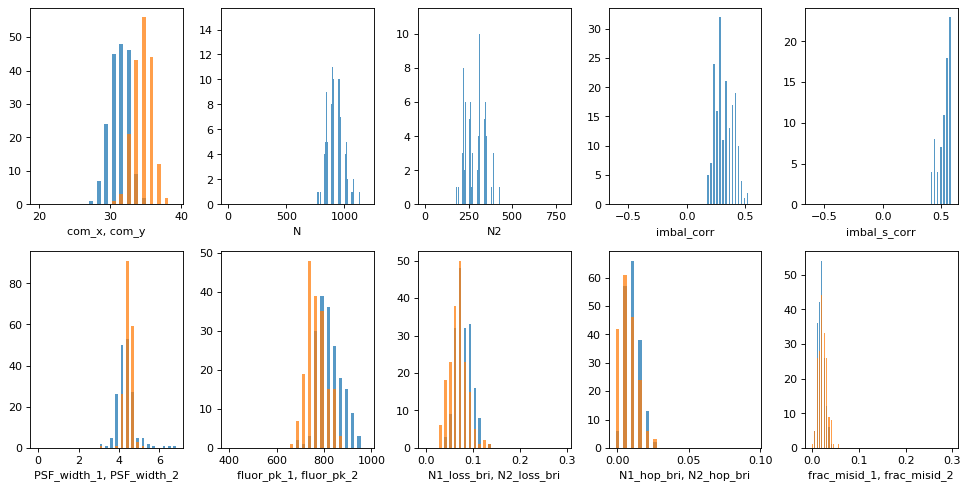

Image number after post selection:  180


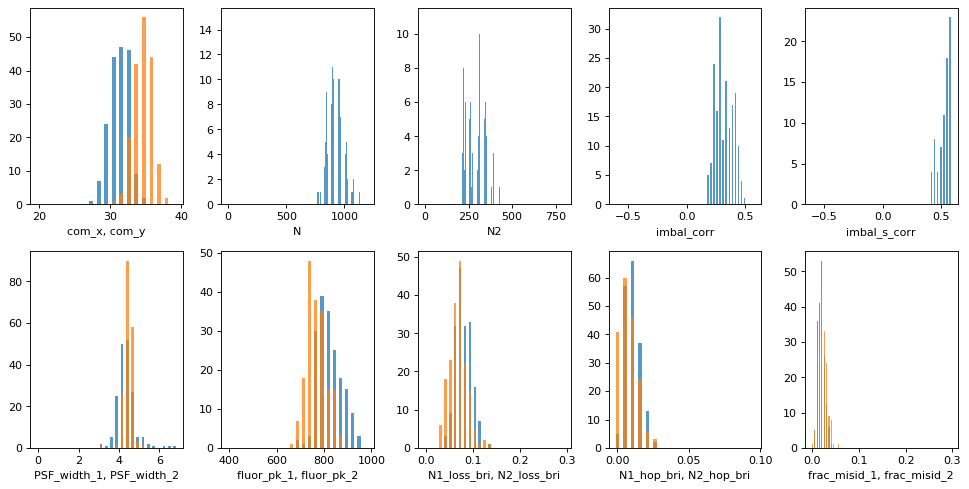

In [126]:
tags = ['dset_03_22_1','dset_03_22_2','dset_03_22_3', 'dset_03_22_4']
nMin = 700; nMax = 1500
n2Min = 200; n2Max = 500
imbalMin = 0.0; imbalMax = 0.9

df = pd.read_csv(glob.glob('*.csv')[0])
df = df[df['Valid']==1]
# Include only tags that in the tags array 
inTagsArr = (np.array(df['Tag']==tags[0]).astype(bool)|False) # initialize to false 
for tag in tags:
    inTagsArr = inTagsArr | np.array(df['Tag']==tag).astype(bool) 
df = df[inTagsArr]

print("Image number before post selection: ",len(df))
show_stats(df)
_df = df
_df = _df[(_df['N']>=nMin)&(_df['N']<=nMax)]
_df = _df[(_df['N2']>=n2Min)&(_df['N2']<=n2Max)]
_df = _df[(_df['imbal_corr']>=imbalMin)&(_df['imbal_corr']<=imbalMax)]
print("Image number after post selection: ",len(_df))
show_stats(_df)
imgs = load_all_imgs(_df)

In [127]:
# Global parameters for analysis/plots
d_max_glob = 4
rMaxChop_glob = 12
numChopBins_glob = 1

## 2 Point Correlations

In [128]:
# 2 point correlation analysis 
def gen2PointCorrPlots(key, imgs,pltRangeg2):
    print(key)
    # Generate data 
    d_arr, r_arr, c_arr = get_c_ImgArrs([imgs[key[0]], imgs[key[1]]], d_max=d_max_glob) # Array of 2D Images with connected correlator at that location, for each d
    c_sum_arr = build_c_sum_from_c(d_arr, r_arr, c_arr)

    # Average density images
    img_n_avg = np.average(imgs['n'], axis=0)
    img_n1_avg = np.average(imgs[key[0]], axis=0)
    img_n2_avg = np.average(imgs[key[1]], axis=0)

    # Generate plots (can be done separately)
    chop_mask_arr = gen_chop_mask_radial_arr(rMaxChop_glob,numChopBins_glob, img_n_avg)
    for chop_mask in chop_mask_arr:
        postProcessDataAndPlot_2Point(key, d_arr, r_arr, c_arr, c_sum_arr, chop_mask, img_n_avg, img_n1_avg, img_n2_avg,pltRangeg2)
        
def postProcessDataAndPlot_2Point(key, d_arr, r_arr, c_arr, c_sum_arr, chop_mask, img_n_avg, img_n1_avg, img_n2_avg,pltRangeg2): 
    startPlotScaleInd = 2
    
    n_val, n_err = extract_binned_vals_in_img(chop_mask, img_n_avg)
    n1_val, n1_err = extract_binned_vals_in_img(chop_mask, img_n1_avg)
    n2_val, n2_err = extract_binned_vals_in_img(chop_mask, img_n2_avg)
    
    # Extract binned correlator values 
    c_vals, c_errs = extract_binned_vals_in_d_arr(chop_mask, c_arr, d_arr)
    c_sum_vals, c_sum_errs = extract_binned_vals_in_d_arr(chop_mask, c_sum_arr, d_arr)
    # Build correlation matrix 
    cmat = build_cmat(d_arr, c_vals)
    c_summat = build_cmat(d_arr, c_sum_vals)
    
    print("<n> = {:.3f} +/- {:.3f}".format(n_val, n_err))
    
    # Plotting result
    fig, axs = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
    g2pltScale =  1.3*np.max(np.abs(c_vals[startPlotScaleInd:]/(n1_val*n2_val)))
    pCondpltScaleMid = c_sum_vals[0]/(n1_val)
    pCondpltScaleDelta = 1.3*np.max(np.abs(c_sum_vals[startPlotScaleInd:]/(n1_val)-pCondpltScaleMid))
    # Plot
    axs[0].imshow(cmat/(n1_val*n2_val)+1, cmap='RdBu_r', vmin=1-g2pltScale, vmax=1+g2pltScale)
    jerrbar(axs[1], r_arr, c_vals/(n1_val*n2_val)+1, yerr=c_vals/(n1_val*n2_val)*np.sqrt(np.divide(c_errs,c_vals)**2+(n1_err/n1_val)**2+(n2_err/n2_val)**2))
    jplot(axs[1], [r_arr[0], r_arr[-1]], [1, 1], ls='--', color='0.5')
    setlims(axs[1], None, [1-g2pltScale, 1 + g2pltScale])
    setlabels(axs[1], ["r [sites]", "g2("+ str(key[0])+","+str(key[1])+")"])
    axs[2].imshow(c_summat/n1_val, cmap='RdBu_r', vmin=pCondpltScaleMid-pCondpltScaleDelta, vmax=pCondpltScaleMid+pCondpltScaleDelta)
    jerrbar(axs[3], r_arr, c_sum_vals/n1_val, yerr=(c_sum_vals/n1_val)*np.sqrt(np.divide(c_sum_errs,c_sum_vals)**2+(n1_err/n1_val)**2))
    jplot(axs[3], [r_arr[0], r_arr[-1]], [c_sum_vals[0]/n1_val, c_sum_vals[0]/n1_val], ls='--', color='0.5')
    setlims(axs[3], None, [pCondpltScaleMid-pCondpltScaleDelta,pCondpltScaleMid+pCondpltScaleDelta])
    setlabels(axs[3], ["r [sites]", "Sum(Cond. Prob. of "+str(key[1])+" at x for x<=r)"])
    
    axs[4].imshow(cmat/(n1_val*n2_val)+1, cmap='RdBu_r', vmin=1-pltRangeg2, vmax=1+pltRangeg2)
    plt.show()

['p', 'p']
<n> = 0.625 +/- 0.006


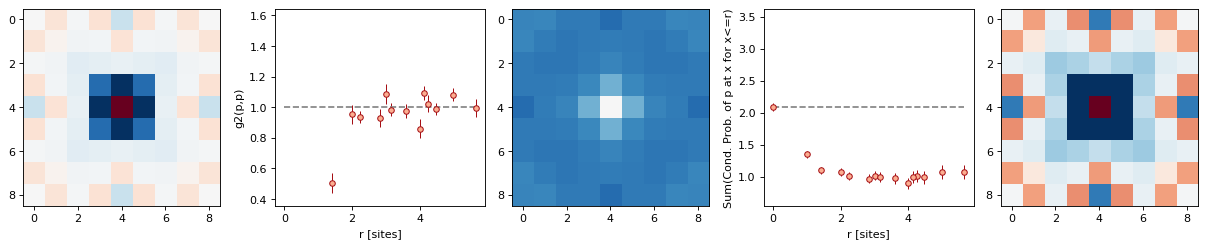

['p', 'p']
<n> = 0.611 +/- 0.005


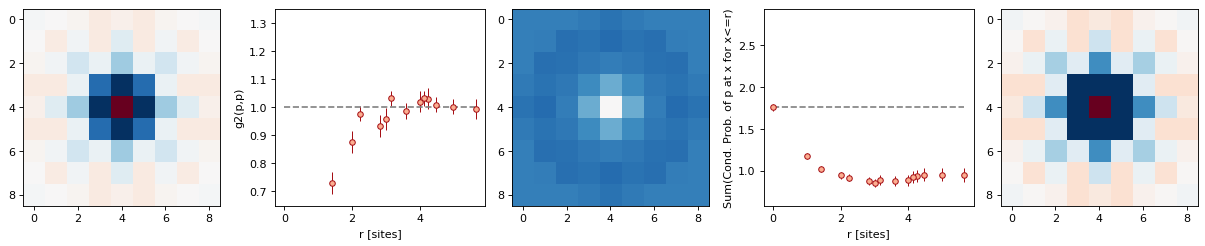

['p', 'p']
<n> = 0.572 +/- 0.005


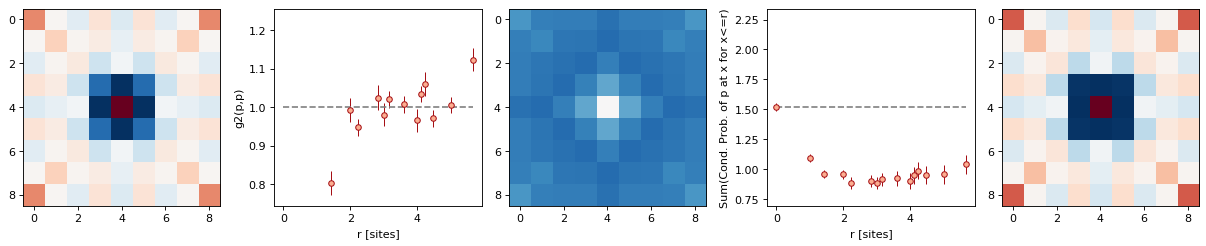

['p', 'p']
<n> = 0.542 +/- 0.007


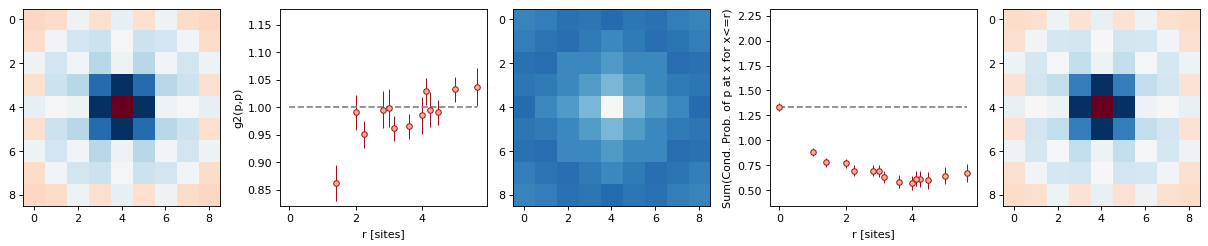

In [129]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 4
key = ['p','p']
fixedPlotRange = 0.2

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange)

['d', 'd']
<n> = 0.625 +/- 0.006


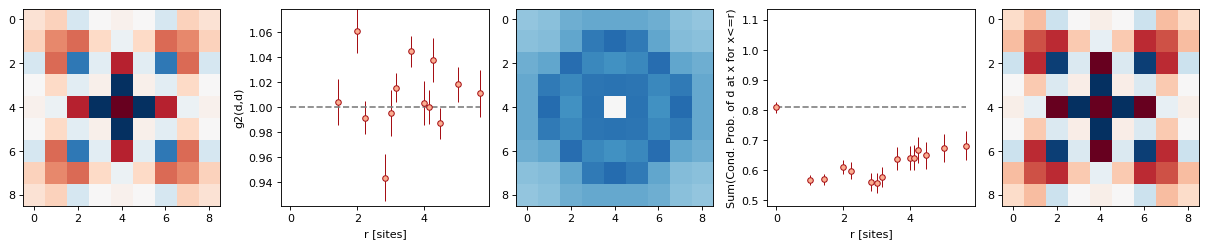

['d', 'd']
<n> = 0.611 +/- 0.005


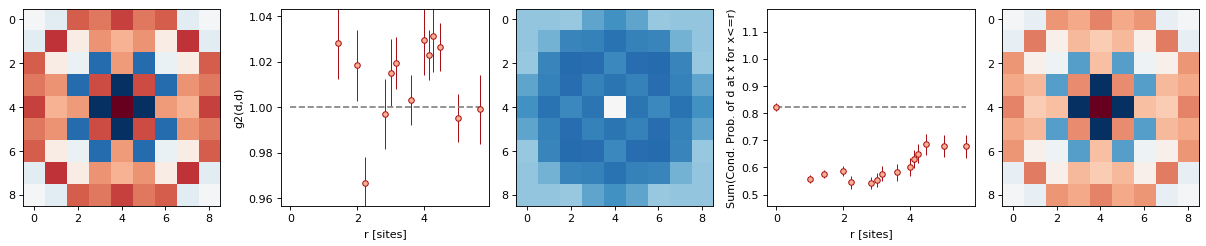

['d', 'd']
<n> = 0.572 +/- 0.005


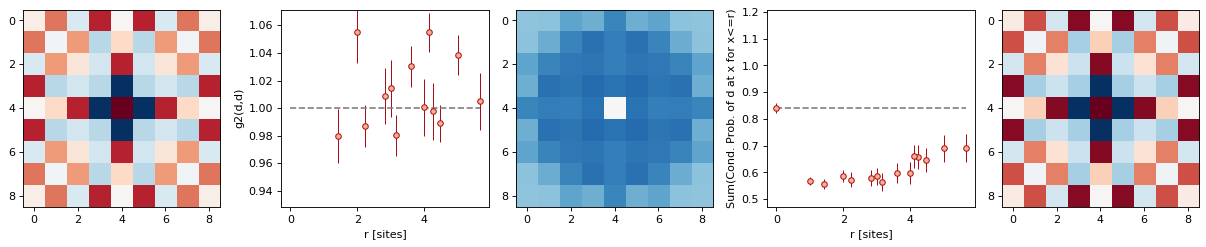

['d', 'd']
<n> = 0.542 +/- 0.007


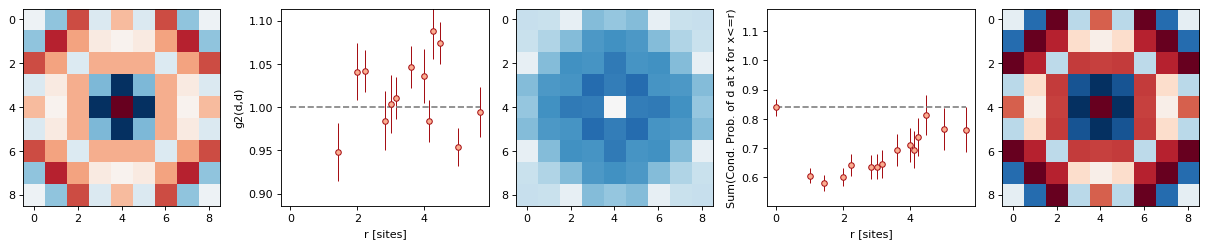

In [130]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 4
key = ['d','d']
fixedPlotRange = 0.06

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange)

['n', 'n']
<n> = 0.625 +/- 0.006


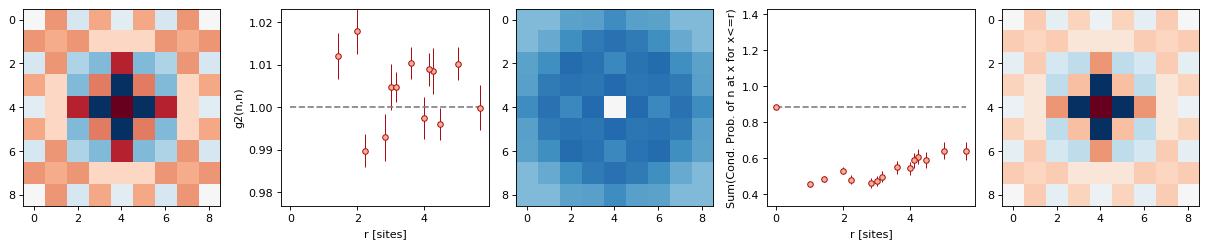

['n', 'n']
<n> = 0.611 +/- 0.005


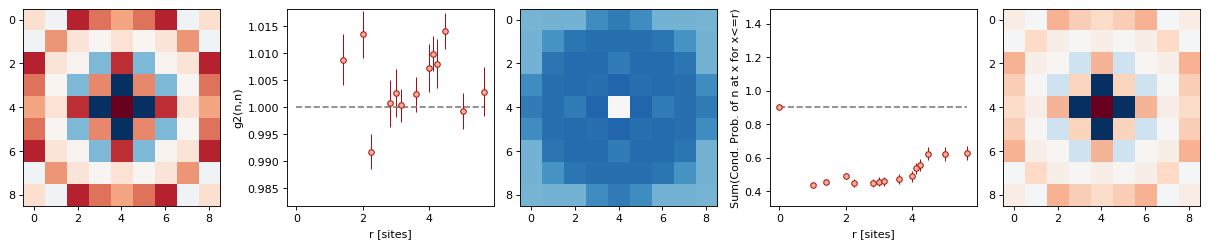

['n', 'n']
<n> = 0.572 +/- 0.005


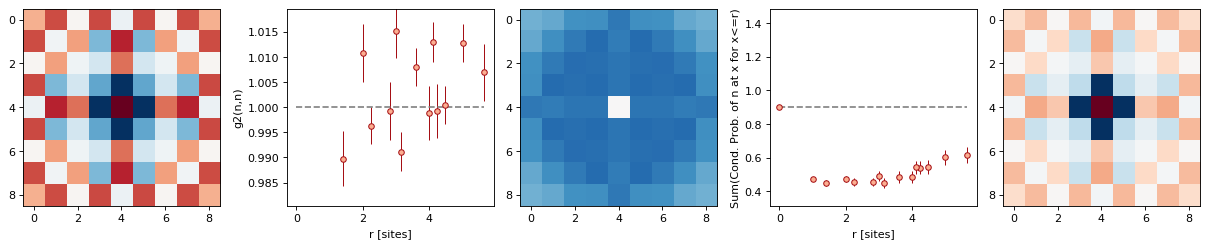

['n', 'n']
<n> = 0.542 +/- 0.007


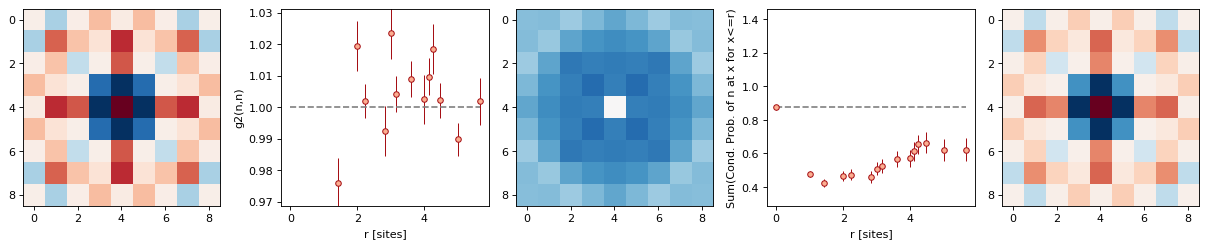

In [131]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 4
key = ['n','n']
fixedPlotRange = 0.04

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange)

['s_up_isol', 's_up_isol']
<n> = 0.626 +/- 0.008


['s_up_isol', 's_up_isol']
<n> = 0.618 +/- 0.006


['s_up_isol', 's_up_isol']
<n> = 0.610 +/- 0.006


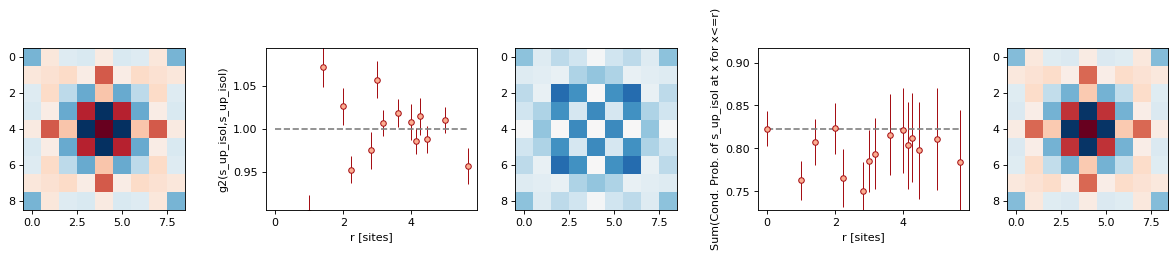

['s_up_isol', 's_up_isol']
<n> = 0.576 +/- 0.006


['s_up_isol', 's_up_isol']
<n> = 0.552 +/- 0.006


['s_up_isol', 's_up_isol']
<n> = 0.548 +/- 0.010


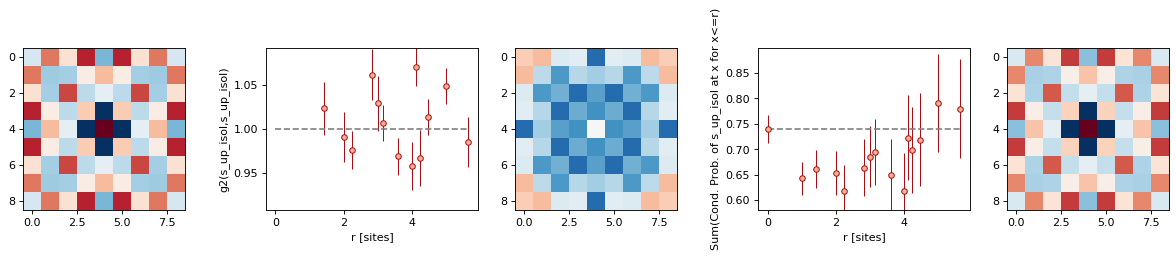

In [132]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 6
key = ['s_up_isol','s_up_isol']
fixedPlotRange = 0.1

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange)

['p_isol', 'p_isol']
<n> = 0.625 +/- 0.006


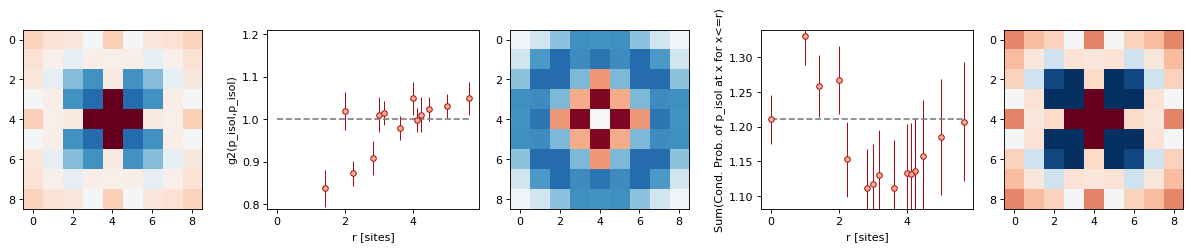

['p_isol', 'p_isol']
<n> = 0.611 +/- 0.005


['p_isol', 'p_isol']
<n> = 0.572 +/- 0.005


['p_isol', 'p_isol']
<n> = 0.542 +/- 0.007


In [133]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 4
key = ['p_isol','p_isol']
fixedPlotRange = 0.1

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange)

['dn', 'p']
<n> = 0.625 +/- 0.006


['dn', 'p']
<n> = 0.611 +/- 0.005


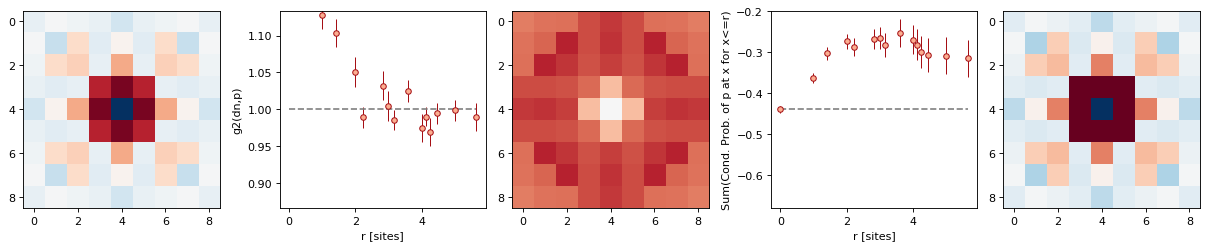

['dn', 'p']
<n> = 0.572 +/- 0.005


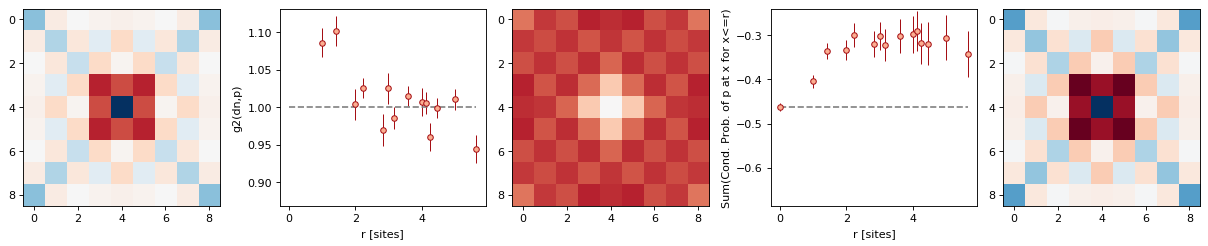

['dn', 'p']
<n> = 0.542 +/- 0.007


In [134]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 4
key = ['dn','p']
fixedPlotRange = 0.1

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange)

['up', 'p']
<n> = 0.625 +/- 0.006


['up', 'p']
<n> = 0.611 +/- 0.005


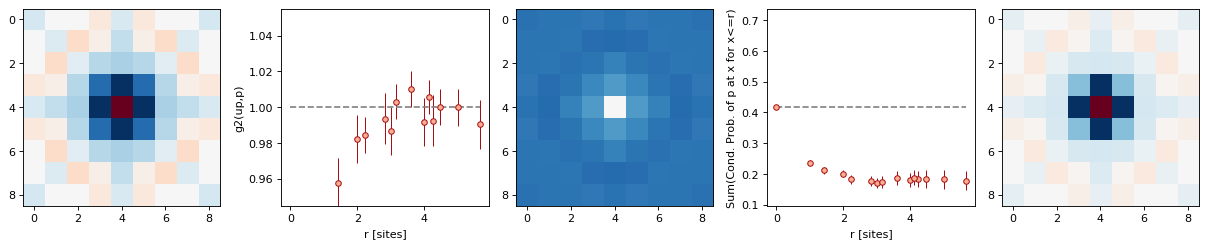

['up', 'p']
<n> = 0.572 +/- 0.005


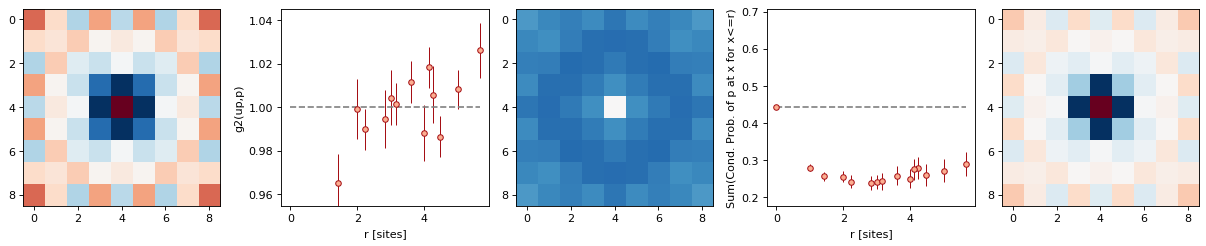

['up', 'p']
<n> = 0.542 +/- 0.007


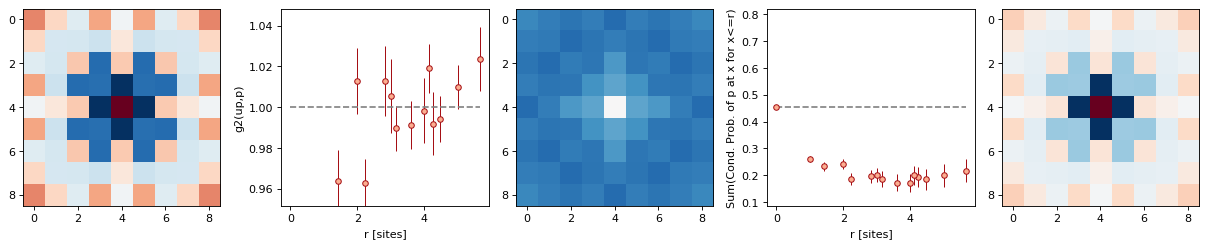

In [135]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 4
key = ['up','p']
fixedPlotRange = 0.1

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange)

In [136]:
# # # Isolated spins 
# gen2PointCorrPlots(['p_isol','p_isol'],imgs)
# gen2PointCorrPlots(['s_up_isol','s_up_isol'],imgs)
# gen2PointCorrPlots(['s_dn_isol','s_dn_isol'],imgs)
# gen2PointCorrPlots(['s_up_isol','s_dn_isol'],imgs)

# # Singlons
# gen2PointCorrPlots(['p','p'],imgs)
# gen2PointCorrPlots(['s','s'],imgs)
# gen2PointCorrPlots(['s_up','s_up'],imgs)
# gen2PointCorrPlots(['s_dn','s_dn'],imgs)
# gen2PointCorrPlots(['s_up','s_dn'],imgs)

# # Densities
# gen2PointCorrPlots(['n','n'],imgs)
# gen2PointCorrPlots(['p_dh','p_dh'],imgs)
# gen2PointCorrPlots(['d','d'],imgs)
# gen2PointCorrPlots(['h','h'],imgs)
# gen2PointCorrPlots(['d','h'],imgs)

## 3 Point Correlations

In [57]:
# 3 point correlation analysis 
def gen3PointCorrPlots(key,imgs,d1to2):    
    # Generate data 
    # 3 point correlator 
    [d_arr, r_arr, nijk_arr, nij_arr, nik_arr, 
     njk_arr, ni_arr, nj_arr, nk_arr] =  get_nijk_ImgArrs(imgs[key[0]],imgs[key[1]], imgs[key[2]],d1to2, d_max=d_max_glob) 
        # Array of 2D Images with connected correlator expectation value at that location, for each d

    # Compute distance to center of second two correlators 
    r0ToCOMof12_arr = np.array([np.sqrt((_d[0]+d1to2[0]/2.0)**2 + (_d[1]+d1to2[1]/2.0)**2) for _d in d_arr])
    
    # Generate plots (can be done separately)
    chop_mask_arr = gen_chop_mask_radial_arr(rMaxChop_glob,numChopBins_glob, np.average(imgs['n'], axis=0))
    for chop_mask in chop_mask_arr:
        nijk_SummaryArr, cijk_SummaryArr, cjk_cond_SummaryArr, nijk_cond_SummaryArr = postProcessData_ExtractCorrelators(chop_mask, d_arr, nijk_arr, nij_arr, nik_arr, njk_arr, ni_arr, nj_arr, nk_arr)
        
        print("d1to2: ", d1to2)
        # print("<n> = {:.3f} +/- {:.3f}".format(n_val, n_err))
        postProcessData_MultiPlot(key, d_arr, r0ToCOMof12_arr, d1to2, nijk_SummaryArr, cijk_SummaryArr, cjk_cond_SummaryArr, nijk_cond_SummaryArr)
        plt.show()
        
def postProcessData_ExtractCorrelators(chop_mask, d_arr, nijk_arr, nij_arr, nik_arr, njk_arr, ni_arr, nj_arr, nk_arr):     
    # Extract binned expected values 
    nijk_vals, nijk_errs = extract_binned_vals_in_d_arr(chop_mask, nijk_arr, d_arr)
    nij_vals, nij_errs = extract_binned_vals_in_d_arr(chop_mask, nij_arr, d_arr)
    nik_vals, nik_errs = extract_binned_vals_in_d_arr(chop_mask, nik_arr, d_arr)
    njk_vals, njk_errs = extract_binned_vals_in_d_arr(chop_mask, njk_arr, d_arr)
    ni_vals, ni_errs = extract_binned_vals_in_d_arr(chop_mask, ni_arr, d_arr)
    nj_vals, nj_errs = extract_binned_vals_in_d_arr(chop_mask, nj_arr, d_arr)
    nk_vals, nk_errs = extract_binned_vals_in_d_arr(chop_mask, nk_arr, d_arr)
    nijk_SummaryArr = [[nijk_vals, nijk_errs], [nij_vals, nij_errs], [nik_vals, nik_errs], [njk_vals, njk_errs], 
                       [ni_vals, ni_errs], [nj_vals, nj_errs], [nk_vals, nk_errs]]
    
    # Now extract the various connected correlators, but only bin after computing the correlator at each pixel in image
    # Normal connected correlators 
    cijk_vals, cijk_errs = extract_binned_vals_in_d_arr(chop_mask, nijk_arr 
                                                        - np.multiply(nk_arr,nij_arr)
                                                        - np.multiply(nj_arr,nik_arr)
                                                        - np.multiply(ni_arr,njk_arr)
                                                        +2*np.multiply(ni_arr,np.multiply(nj_arr,nk_arr)), d_arr)
    cij_vals, cij_errs = extract_binned_vals_in_d_arr(chop_mask, nij_arr - np.multiply(ni_arr,nj_arr), d_arr)
    cik_vals, cik_errs = extract_binned_vals_in_d_arr(chop_mask, nik_arr - np.multiply(ni_arr,nk_arr), d_arr)
    cjk_vals, cjk_errs = extract_binned_vals_in_d_arr(chop_mask, njk_arr - np.multiply(nj_arr,nk_arr), d_arr)
    cijk_SummaryArr = [[cijk_vals, cijk_errs], [cij_vals, cij_errs], [cik_vals, cik_errs], [cjk_vals, cjk_errs]]
    
    
    # Conditional connected correlator - bin over numerator first (to reduce noise) and denominator (to not divide by 0), then sum errors
        # Numerator is desired value times n0**2
    cjk_cond_NUMERATOR_arr = np.array(nijk_arr)*np.array(ni_arr) - np.array(nij_arr)*np.array(nik_arr)
    cjk_cond_DENOMINATOR_arr = np.array(ni_arr)*np.array(ni_arr)
    cjk_cond_NUMERATOR_vals, cjk_cond_NUMERATOR_errs = extract_binned_vals_in_d_arr(chop_mask,cjk_cond_NUMERATOR_arr, d_arr)
    cjk_cond_DENOMINATOR_vals, cjk_cond_DENOMINATOR_errs = extract_binned_vals_in_d_arr(chop_mask,cjk_cond_DENOMINATOR_arr, d_arr)
    cjk_cond_vals = np.divide(cjk_cond_NUMERATOR_vals,cjk_cond_DENOMINATOR_vals)
    cjk_cond_errs = np.divide(cjk_cond_NUMERATOR_vals,cjk_cond_DENOMINATOR_vals)*np.sqrt(np.divide(cjk_cond_NUMERATOR_errs,cjk_cond_NUMERATOR_vals)**2 
                                                                         + 
                                                                        np.divide(cjk_cond_DENOMINATOR_errs,cjk_cond_DENOMINATOR_vals)**2)    
    # Get cjk_cond_delta_vals and errors 
        # Numerator is desired value times n0**2
    cjk_cond_delta_NUMERATOR_arr = (np.array(nijk_arr)*np.array(ni_arr) - np.array(nij_arr)*np.array(nik_arr)
                                   -
                                    (np.array(njk_arr) - np.array(nj_arr)*np.array(nk_arr))*np.array(ni_arr)*np.array(ni_arr)
                                   )
    cjk_cond_delta_DENOMINATOR_arr = np.array(ni_arr)*np.array(ni_arr)
    cjk_cond_delta_NUMERATOR_vals, cjk_cond_delta_NUMERATOR_errs = extract_binned_vals_in_d_arr(chop_mask,cjk_cond_delta_NUMERATOR_arr, d_arr)
    cjk_cond_delta_DENOMINATOR_vals, cjk_cond_delta_DENOMINATOR_errs = extract_binned_vals_in_d_arr(chop_mask,cjk_cond_delta_DENOMINATOR_arr, d_arr)
    cjk_cond_delta_vals = np.divide(cjk_cond_delta_NUMERATOR_vals,cjk_cond_delta_DENOMINATOR_vals)
    cjk_cond_delta_errs = np.divide(cjk_cond_delta_NUMERATOR_vals,cjk_cond_delta_DENOMINATOR_vals)*np.sqrt(np.divide(cjk_cond_delta_NUMERATOR_errs,cjk_cond_delta_NUMERATOR_vals)**2
                                                                                                           +
                                                                                                           np.divide(cjk_cond_delta_DENOMINATOR_errs,cjk_cond_delta_DENOMINATOR_vals)**2)
    cjk_cond_delta_effect_size_vals = cjk_cond_delta_vals/cjk_cond_delta_errs
    cjk_cond_SummaryArr = [[cjk_cond_vals, cjk_cond_errs], [cjk_cond_delta_vals, cjk_cond_delta_errs],[cjk_cond_delta_effect_size_vals]]
    
    # Get conditional densities
    nj_cond_vals, nj_cond_errs = np.divide(nij_vals,ni_vals), np.divide(nij_vals,ni_vals)*np.sqrt((np.divide(ni_errs,ni_vals))**2 + (np.divide(nij_errs,nij_vals))**2)
    nk_cond_vals, nk_cond_errs = np.divide(nik_vals,ni_vals), np.divide(nik_vals,ni_vals)*np.sqrt((np.divide(ni_errs,ni_vals))**2 + (np.divide(nik_errs,nik_vals))**2)
    njnk_cond_vals = np.divide(nik_vals,ni_vals)*np.divide(nij_vals,ni_vals)
    njnk_cond_errs = njnk_cond_vals*np.sqrt(4*(np.divide(ni_errs,ni_vals))**2 + (np.divide(nik_errs,nik_vals))**2+ (np.divide(nij_errs,nij_vals))**2)
    nijk_cond_SummaryArr = [[nj_cond_vals, nj_cond_errs],[nk_cond_vals, nk_cond_errs],[njnk_cond_vals,njnk_cond_errs]]
    
    return nijk_SummaryArr, cijk_SummaryArr, cjk_cond_SummaryArr, nijk_cond_SummaryArr

def postProcessData_MultiPlot(key, d_arr, r0ToCOMof12_arr, d1to2, nijk_SummaryArr, cijk_SummaryArr, cjk_cond_SummaryArr, nijk_cond_SummaryArr): 
    # Extract data
    cijk_vals, cijk_errs = cijk_SummaryArr[0]
    cjk_vals, cjk_errs = cijk_SummaryArr[3]
    cjk_cond_vals, cjk_cond_errs = cjk_cond_SummaryArr[0]
    cjk_cond_delta_vals, cjk_cond_delta_errs = cjk_cond_SummaryArr[1]
    cjk_cond_delta_effect_size_vals = cjk_cond_SummaryArr[2][0]
    nj_vals, nj_errs = nijk_SummaryArr[5]
    nk_vals, nk_errs = nijk_SummaryArr[6]
    nj_cond_vals, nj_cond_errs = nijk_cond_SummaryArr[0]
    nk_cond_vals, nk_cond_errs = nijk_cond_SummaryArr[1]
    njnk_cond_vals, njnk_cond_errs = nijk_cond_SummaryArr[2]
    
    # Build correlation matrix, which is shifted later during plotting
    cijk_mat = build_cmat_NonSymAvg(d_arr, cijk_vals)
    cjk_mat = build_cmat_NonSymAvg(d_arr, cjk_vals)
    cjk_cond_mat = build_cmat_NonSymAvg(d_arr, cjk_cond_vals)
    cjk_cond_delta_mat = build_cmat_NonSymAvg(d_arr, cjk_cond_delta_vals)
    nj_mat = build_cmat_NonSymAvg(d_arr, nj_vals)
    nk_mat = build_cmat_NonSymAvg(d_arr, nk_vals)
    nj_cond_mat = build_cmat_NonSymAvg(d_arr, nj_cond_vals)
    nk_cond_mat = build_cmat_NonSymAvg(d_arr, nk_cond_vals)
    njnk_cond_mat = build_cmat_NonSymAvg(d_arr, njnk_cond_vals)
    
    # Remove points corresponding to the original displacemnet 
    def removeMatrixPoints(_mat, _d_arr, _d1to2):
        _matDeleted = np.copy(_mat)
        _dispMax = np.max(np.array(_d_arr))
        _matDeleted[_dispMax, _dispMax] = np.nan 
        _matDeleted[_dispMax - _d1to2[0], _dispMax - _d1to2[1]] = np.nan 
        _maxVal = np.max(_matDeleted[~np.isnan(_matDeleted)]) # remove nan values then find max 
        _minVal = np.min(_matDeleted[~np.isnan(_matDeleted)]) # remove nan values then find min
        return _matDeleted, _maxVal, _minVal
    def removeDataArrPoints(_datArr, _d_arr, _d1to2):
        _d_arr = np.array(_d_arr)
        _d1to2 = np.array(_d1to2)
        wheredispEqd1to2 = np.intersect1d(np.where(_d_arr[:,0]==-_d1to2[0])[0],np.where(_d_arr[:,1]==-_d1to2[1])[0])
        wheredispEq0 = np.intersect1d(np.where(_d_arr[:,0]==0)[0],np.where(_d_arr[:,1]==0)[0])
        _datArrDeleted = np.copy(_datArr)
        _datArrDeleted[wheredispEqd1to2] = np.nan
        _datArrDeleted[wheredispEq0] = np.nan
        _maxVal = np.max(_datArrDeleted[~np.isnan(_datArrDeleted)]) # remove nan values then find max 
        _minVal = np.min(_datArrDeleted[~np.isnan(_datArrDeleted)]) # remove nan values then find min
        return _datArrDeleted, _maxVal, _minVal
    # delete matrix points
    cijk_mat, cijk_mat_max, cijk_mat_min = removeMatrixPoints(cijk_mat, d_arr, d1to2)
    cjk_mat, cjk_mat_max, cjk_mat_min = removeMatrixPoints(cjk_mat, d_arr, d1to2)
    cjk_cond_mat, cjk_cond_mat_max, cjk_cond_mat_min = removeMatrixPoints(cjk_cond_mat, d_arr, d1to2)
    cjk_cond_delta_mat, cjk_cond_delta_mat_max, cjk_cond_delta_mat_min = removeMatrixPoints(cjk_cond_delta_mat, d_arr, d1to2)
    nj_mat, nj_mat_max, nj_mat_min = removeMatrixPoints(nj_mat, d_arr, d1to2)
    nk_mat, nk_mat_max, nk_mat_min = removeMatrixPoints(nk_mat, d_arr, d1to2)
    nj_cond_mat, nj_cond_mat_max, nj_cond_mat_min = removeMatrixPoints(nj_cond_mat, d_arr, d1to2)
    nk_cond_mat, nk_cond_mat_max, nk_cond_mat_min = removeMatrixPoints(nk_cond_mat, d_arr, d1to2)
    njnk_cond_mat, njnk_cond_mat_max, njnk_cond_mat_min = removeMatrixPoints(njnk_cond_mat, d_arr, d1to2)
    # and from data arrays
    cijk_vals, cijk_vals_max, cijk_vals_min = removeDataArrPoints(cijk_vals, d_arr, d1to2)
    cjk_vals, cjk_vals_max, cjk_vals_min = removeDataArrPoints(cjk_vals, d_arr, d1to2)
    cjk_cond_vals, cjk_cond_vals_max, cjk_cond_vals_min = removeDataArrPoints(cjk_cond_vals, d_arr, d1to2)
    cjk_cond_delta_vals, cjk_cond_delta_vals_max, cjk_cond_delta_vals_min = removeDataArrPoints(cjk_cond_delta_vals, d_arr, d1to2)
    cjk_cond_delta_effect_size_vals, cjk_cond_delta_effect_size_vals_max, cjk_cond_delta_effect_size_vals_min = removeDataArrPoints(cjk_cond_delta_effect_size_vals, d_arr, d1to2)
    nj_vals, nj_vals_max, nj_vals_min = removeDataArrPoints(nj_vals, d_arr, d1to2)
    nk_vals, nk_vals_max, nk_vals_min = removeDataArrPoints(nk_vals, d_arr, d1to2)
    nj_cond_vals, nj_cond_vals_max, nj_cond_vals_min = removeDataArrPoints(nj_cond_vals, d_arr, d1to2)
    nk_cond_vals, nk_cond_vals_max, nk_cond_vals_min = removeDataArrPoints(nk_cond_vals, d_arr, d1to2)
    njnk_cond_vals, njnk_cond_vals_max, njnk_cond_vals_min = removeDataArrPoints(njnk_cond_vals, d_arr, d1to2)
    
    
    # Plotting result
    fig, axs = plt.subplots(2, 9, figsize=(32, 8), constrained_layout=True)
    
    cijk_vals_pltScale = 1.2*np.max([np.abs(cijk_vals_max),np.abs(cijk_vals_min)])
    cjk_vals_pltScale = 1.2*np.max([np.abs(cjk_vals_max),np.abs(cjk_vals_min)])
    cjk_cond_vals_pltScale = 1.2*np.max([np.abs(cjk_cond_vals_max),np.abs(cjk_cond_vals_min)])
    cjk_cond_delta_vals_pltScale = 1.2*np.max([np.abs(cjk_cond_delta_vals_max),np.abs(cjk_cond_delta_vals_min)])
    
    # Basic plots
    # axs[1,0].imshow(cjk_mat, cmap='RdBu_r', vmin= -cjk_vals_pltScale, vmax= cjk_vals_pltScale)
    # axs[1,1].imshow(cjk_cond_mat, cmap='RdBu_r', vmin= -cjk_cond_vals_pltScale, vmax= cjk_cond_vals_pltScale)
    # axs[1,2].imshow(nj_mat, cmap='RdBu_r')
    # axs[1,3].imshow(nj_cond_mat, cmap='RdBu_r')
    # axs[1,4].imshow(nk_mat, cmap='RdBu_r')
    # axs[1,5].imshow(nk_cond_mat, cmap='RdBu_r')
    postProcessData_plt3PointCorrComplex(axs[1,0], cjk_mat, d_arr, d1to2, cjk_mat_min, cjk_mat_max)
    postProcessData_plt3PointCorrComplex(axs[1,1], cjk_cond_mat, d_arr, d1to2, cjk_cond_mat_min, cjk_cond_mat_max)
    postProcessData_plt3PointCorrComplex(axs[1,2], nj_mat, d_arr, d1to2, nj_mat_min, nj_mat_max)
    postProcessData_plt3PointCorrComplex(axs[1,3], nj_cond_mat, d_arr, d1to2, nj_cond_mat_min, nj_cond_mat_max)
    postProcessData_plt3PointCorrComplex(axs[1,4], nk_mat, d_arr, d1to2, nk_mat_min, nk_mat_max)
    postProcessData_plt3PointCorrComplex(axs[1,5], nk_cond_mat, d_arr, d1to2, nk_cond_mat_min, nk_cond_mat_max)
    postProcessData_plt3PointCorrComplex(axs[1,6], cjk_cond_delta_mat, d_arr, d1to2, -cjk_cond_delta_vals_pltScale, cjk_cond_delta_vals_pltScale)
    postProcessData_plt3PointCorrComplex(axs[1,7], njnk_cond_mat, d_arr, d1to2, njnk_cond_mat_min, njnk_cond_mat_max)
    postProcessData_plt3PointCorrComplex(axs[1,8], cijk_mat, d_arr, d1to2, cijk_mat_min, cijk_mat_max)
    
    ax1DPlotNow = axs[0,0]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, cjk_vals, yerr=cjk_errs)
    jplot(ax1DPlotNow, [0,np.max(r0ToCOMof12_arr)], [0,0], ls='-', color='0.2')
    setlims(ax1DPlotNow, None, [-cjk_vals_pltScale,cjk_vals_pltScale])
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "<"+ str(key[1])+","+str(key[2])+">_c"])
    
    ax1DPlotNow = axs[0,1]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, cjk_cond_vals, yerr=cjk_cond_errs)
    jplot(ax1DPlotNow, [0,np.max(r0ToCOMof12_arr)], [0,0], ls='-', color='0.2')
    setlims(ax1DPlotNow, None, [-cjk_cond_vals_pltScale,cjk_cond_vals_pltScale])
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "<"+ str(key[1])+","+str(key[2])+">_c | "+str(key[0])])
    
    ax1DPlotNow = axs[0,2]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, nj_vals, yerr=nj_errs)
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "Density of "+ str(key[1])+" at 1"])
    
    ax1DPlotNow = axs[0,3]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, nj_cond_vals, yerr=nj_errs)
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "Conditioned density of "+ str(key[1])+" at 1"])
    
    ax1DPlotNow = axs[0,4]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, nk_vals, yerr=nk_errs)
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "Density of "+ str(key[2])+" at 2"])
    
    ax1DPlotNow = axs[0,5]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, nk_cond_vals, yerr=nk_errs)
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "Conditioned density of "+ str(key[2])+" at 2"])
    
    ax1DPlotNow = axs[0,6]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, cjk_cond_delta_vals, yerr=cjk_cond_delta_errs)
    jplot(ax1DPlotNow, [0,np.max(r0ToCOMof12_arr)], [0,0], ls='-', color='0.2')
    setlims(ax1DPlotNow, None, [-cjk_cond_delta_vals_pltScale,cjk_cond_delta_vals_pltScale])
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "<"+ str(key[1])+","+str(key[2])+">_c | "+str(key[0])+ " - <"+ str(key[1])+","+str(key[2])+">_c"])
    
    ax1DPlotNow = axs[0,7]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, np.abs(cjk_cond_delta_effect_size_vals), yerr=np.ones(len(cjk_cond_delta_effect_size_vals))/2.0)
    setlims(ax1DPlotNow, None, [0, 1.2*cjk_cond_delta_effect_size_vals_max])
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "Effect size (deviation/uncertainty)"])
    
    ax1DPlotNow = axs[0,8]
    jerrbar(ax1DPlotNow, r0ToCOMof12_arr, cijk_vals, yerr=cijk_errs)
    jplot(ax1DPlotNow, [0,np.max(r0ToCOMof12_arr)], [0,0], ls='-', color='0.2')
    setlims(ax1DPlotNow, None, [-cijk_vals_pltScale,cijk_vals_pltScale])
    setlabels(ax1DPlotNow, ["r to center of target [sites]", "<"+ str(key[1])+","+str(key[2])+">_c | "+str(key[0])+ " - <"+ str(key[1])+","+str(key[2])+">_c"])
    

    # add some titles
    axs[0,0].set_title('Conn. Corr. (unconditioned)')
    axs[0,1].set_title('Conn. Corr. (conditioned)')
    axs[0,2].set_title('nj density (unconditioned)')
    axs[0,3].set_title('nj density (conditioned)')
    axs[0,4].set_title('nk density (unconditioned)')
    axs[0,5].set_title('nk density (conditioned)')
    axs[0,6].set_title('Conn. Corr. Diff.')
    axs[0,7].set_title('Effect size of Conn. Corr. Diff.')
    axs[0,8].set_title('c_ijk 3 point correlator')
    
    axs[1,0].set_title('<nj nk>-<nj><nk>')
    axs[1,1].set_title('<nj nk>-<nj><nk> | ni')
    axs[1,2].set_title('<nj>')
    axs[1,3].set_title('<nj>|ni')
    axs[1,4].set_title('<nk>')
    axs[1,5].set_title('<nk>|ni')
    axs[1,6].set_title('Conn. Corr. Diff.')
    axs[1,7].set_title('(<nj>|ni)(<nk>|ni)')
    axs[1,8].set_title('c_ijk 3 point correlator')
    
def postProcessData_plt3PointCorrComplex(axs, _mat, d_arr, d1to2, _vmin, _vmax):
    # Get display parameters to make 2D plot readable 
    dispMax = np.max(d_arr)
    offsetImg = np.array([-d1to2[0],d1to2[1]]).astype(float)/2.0 # Note you have to flip the sign of one of the axes to get it to offset correctly in imshow 
    extentArr = [-(dispMax+0.5)+offsetImg[1],(dispMax+0.5)+offsetImg[1],-(dispMax+0.5)+offsetImg[0], (dispMax+0.5)+offsetImg[0]]
    axs.imshow(_mat, cmap='RdBu_r', extent = extentArr, vmin= _vmin, vmax= _vmax)
    setlims(axs,[-(dispMax+0.5),(dispMax+0.5)], [-(dispMax+0.5), (dispMax+0.5)]) # set it to have the range expected 
    # add markers for lattice sites
    dotvals = np.array(range(-dispMax,dispMax+1))
    xx, yy = np.meshgrid(dotvals ,dotvals )
    for ii in range(len(dotvals)):
        axs.plot(xx[ii], yy[ii],marker = '.', linestyle = '', color = 'black')
    # Add a line designating the correlator we are looking at here. It must always start at a lattice site and end at another lattice site, 
        # Want to make it as centered as possible, so if shift is larger than or equal to one lattice site, shift it back
    offsetImgShiftToCenter = np.round(offsetImg)
    barPltx, barPlty =[2*offsetImg[1]-offsetImgShiftToCenter[1],-offsetImgShiftToCenter[1]],[2*offsetImg[0]-offsetImgShiftToCenter[0],-offsetImgShiftToCenter[0]]
    barCenterPltx, barCenterPlty = [(barPltx[0]+barPltx[1])/2.0],[(barPlty[0]+barPlty[1])/2.0]
    axs.plot([0],[0], marker = 'o', color = 'black', markersize = 65.0/dispMax) # Origin 
    axs.plot(barCenterPltx, barCenterPlty, marker = 'o', color = 'green', markersize = 35.0/dispMax) # Center of correlator 
    axs.plot(barPltx, barPlty, marker = 'o', linestyle = '-', linewidth=15/dispMax, color = 'green', alpha = 0.5)
    setlabels(axs, ["x COM disp.", "y COM disp. of target"])

d1to2:  [2, 0]


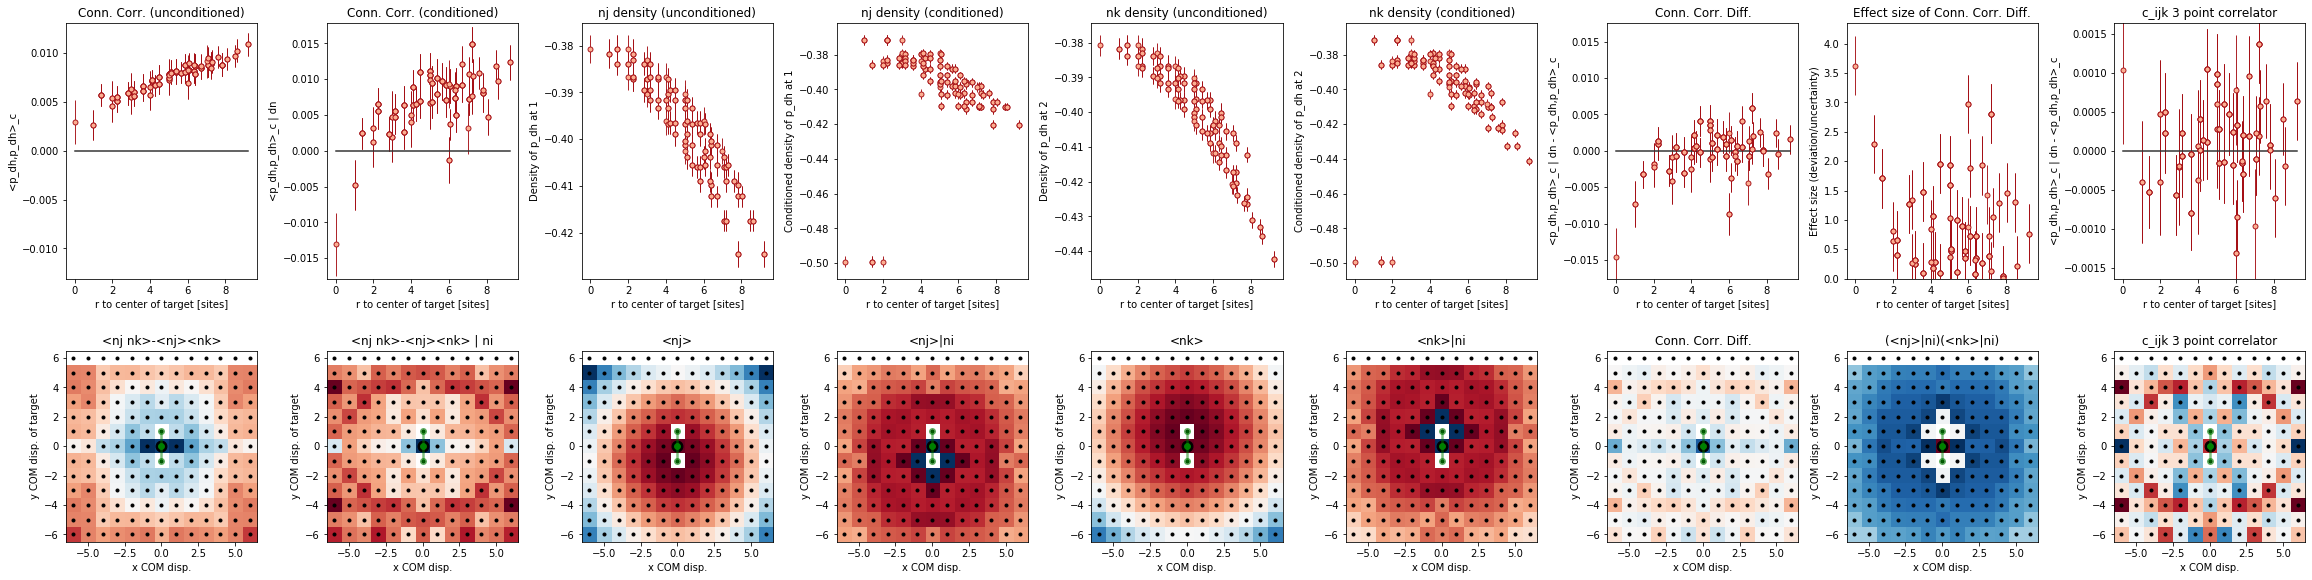

d1to2:  [2, 0]


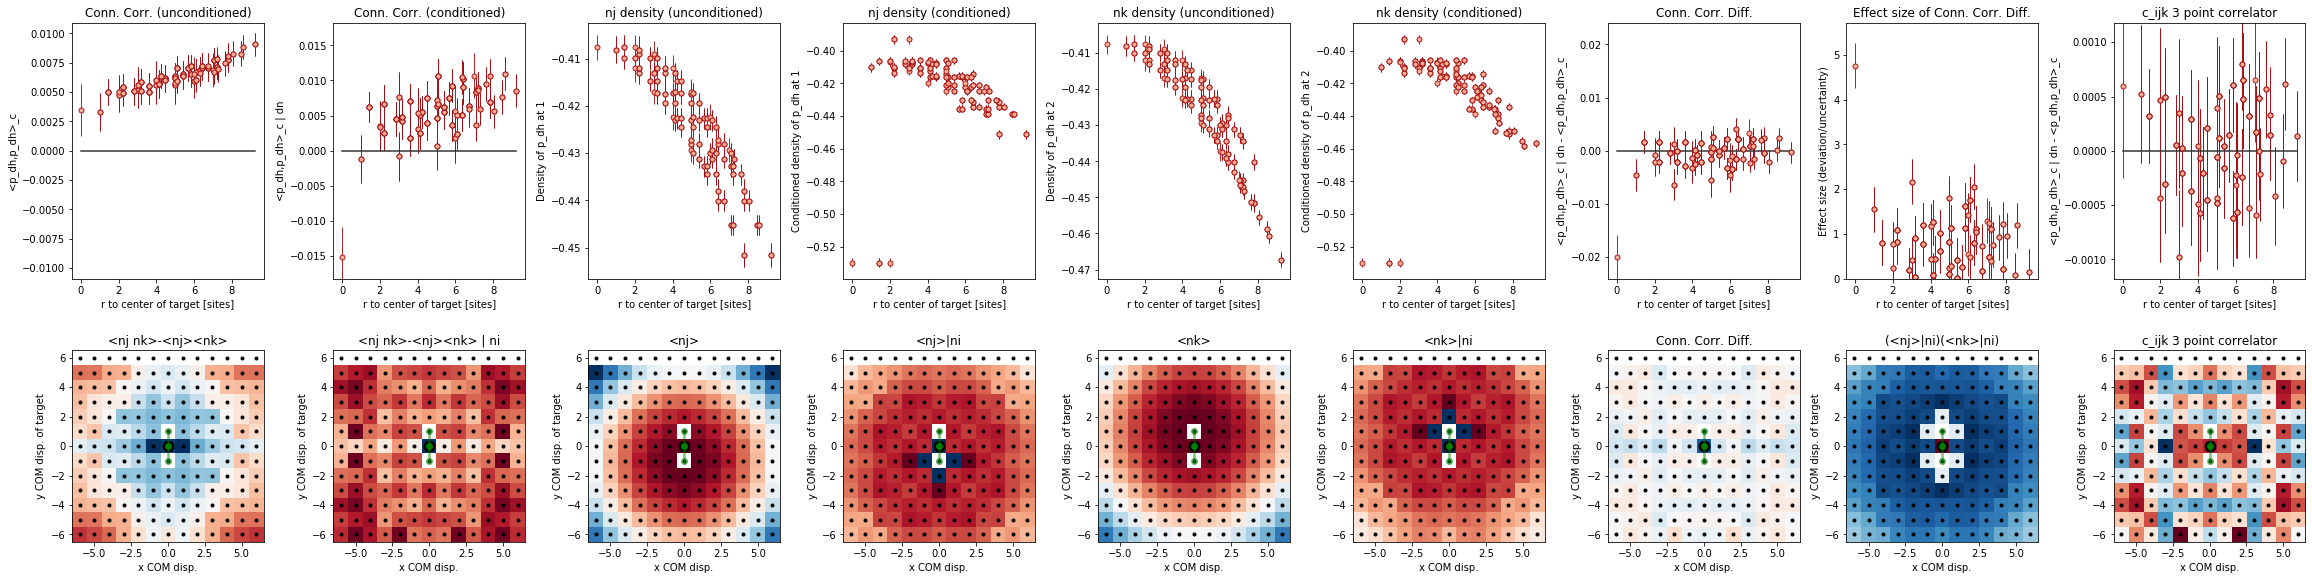

d1to2:  [2, 0]


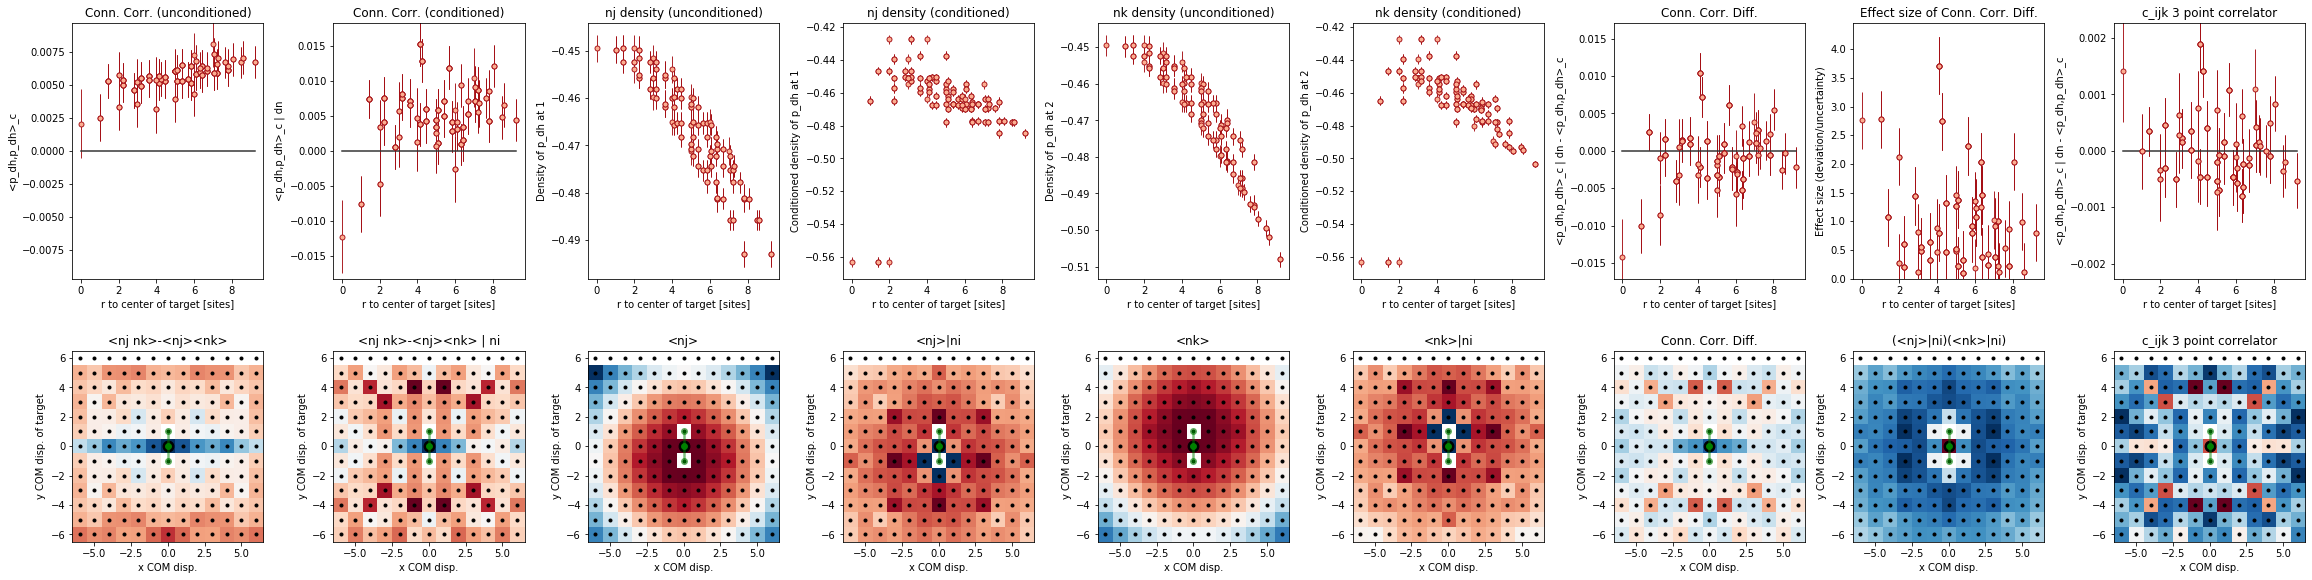

In [95]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 3
key = ['dn','p_dh','p_dh']
d1to2ToDo =[2,0]

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen3PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), d1to2ToDo)

d1to2:  [2, 0]


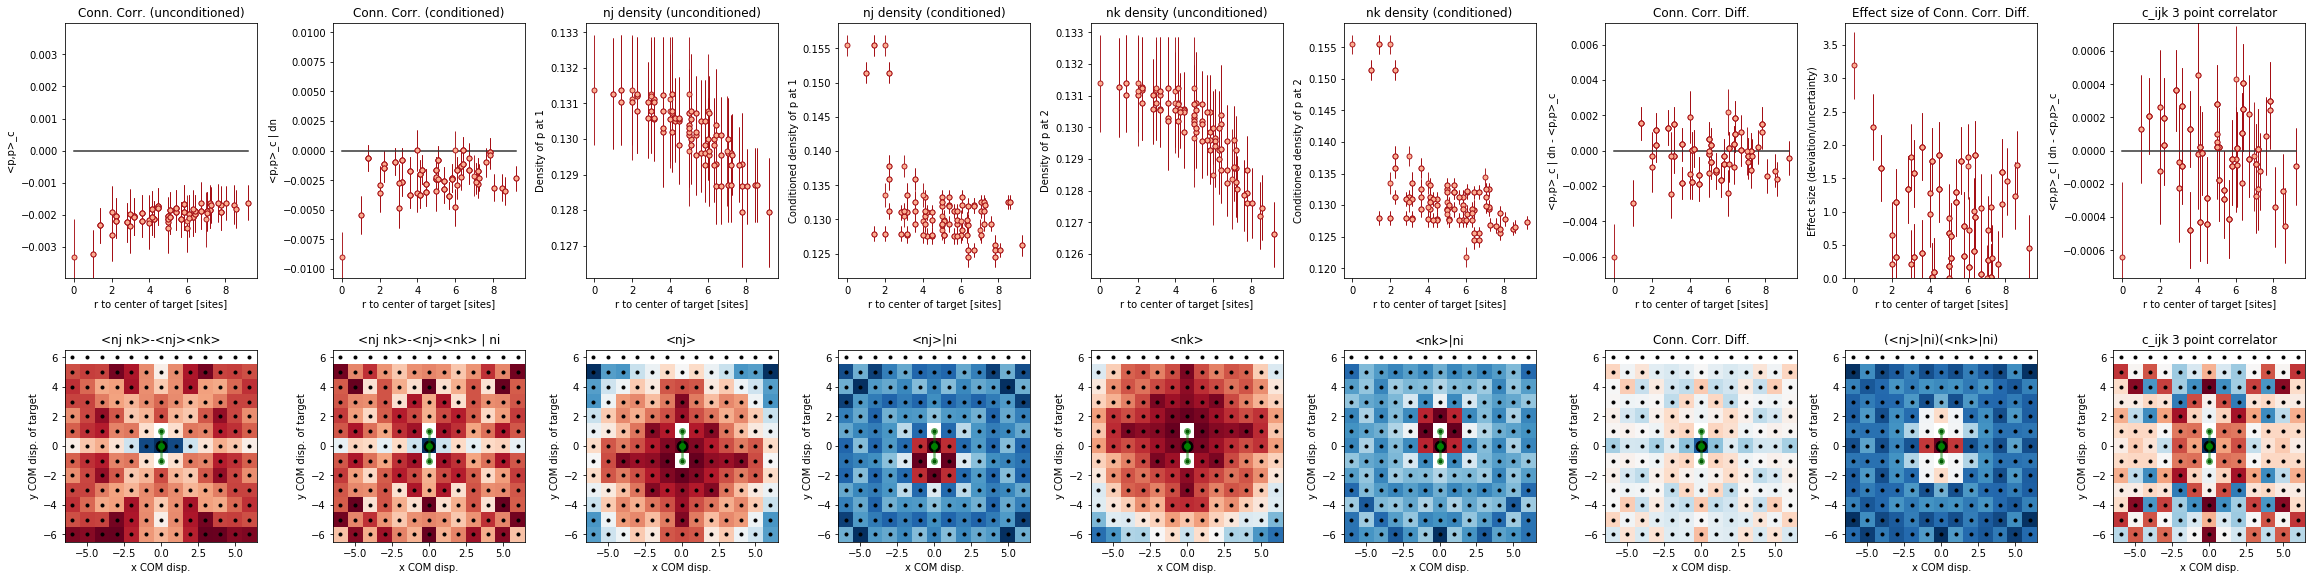

d1to2:  [2, 0]


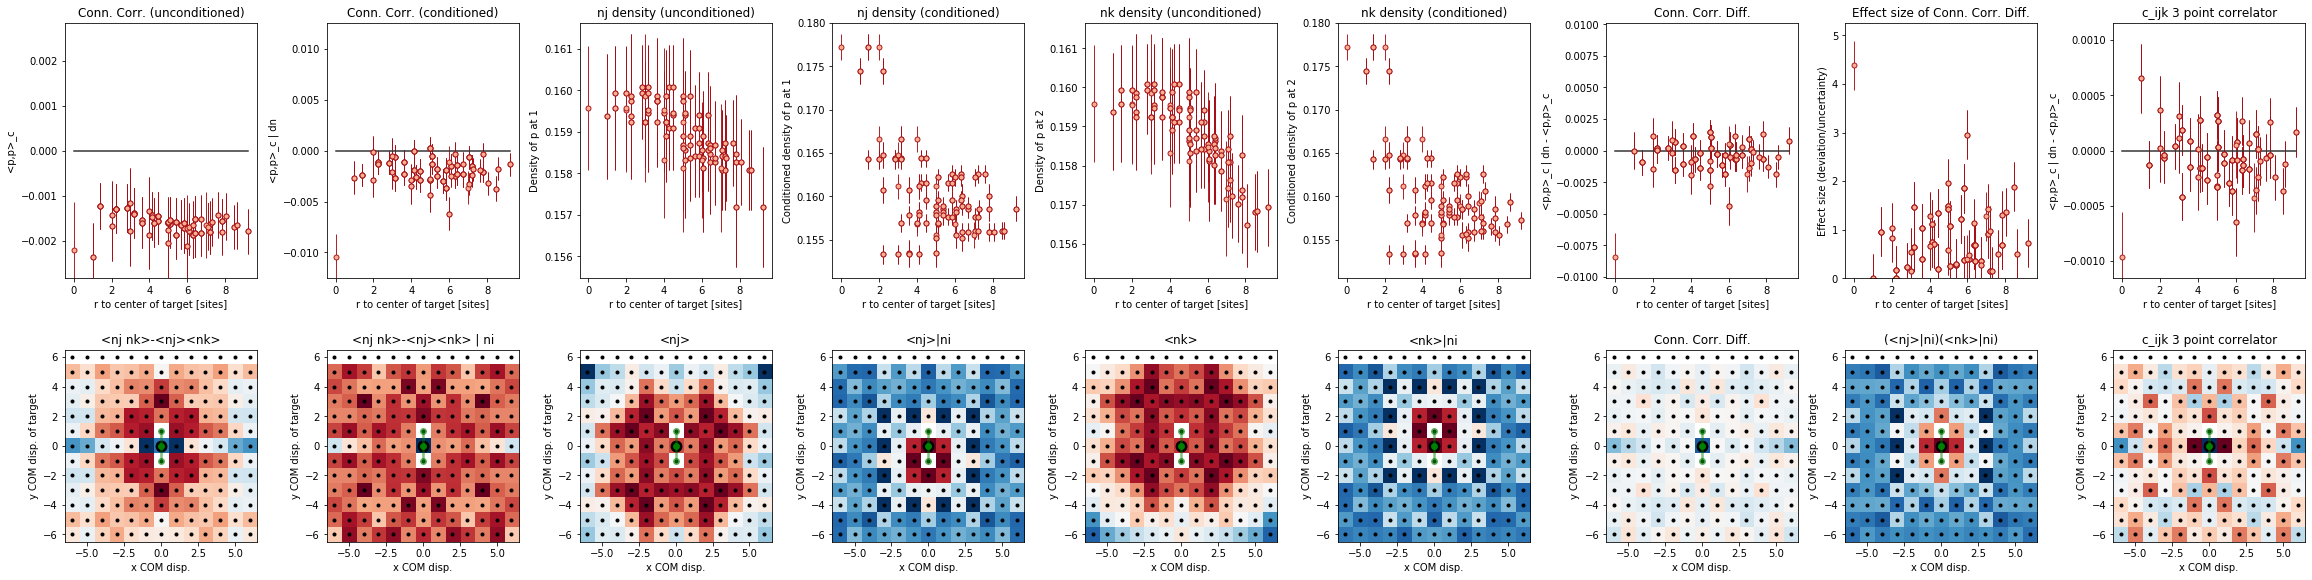

d1to2:  [2, 0]


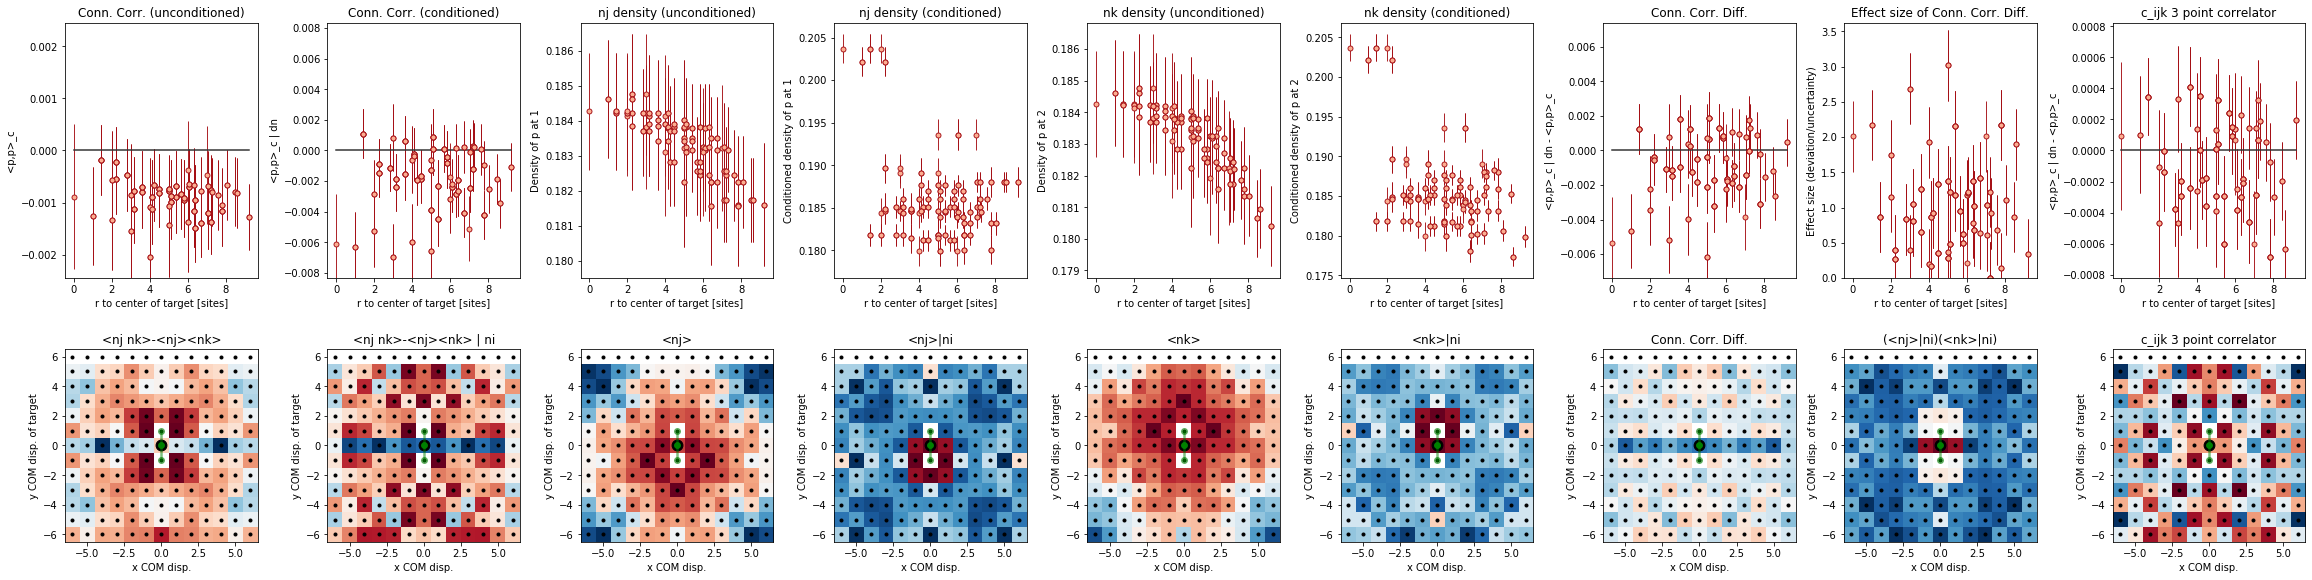

In [90]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 3
key = ['dn','p','p']
d1to2ToDo =[2,0]

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen3PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), d1to2ToDo)

d1to2:  [1, 1]


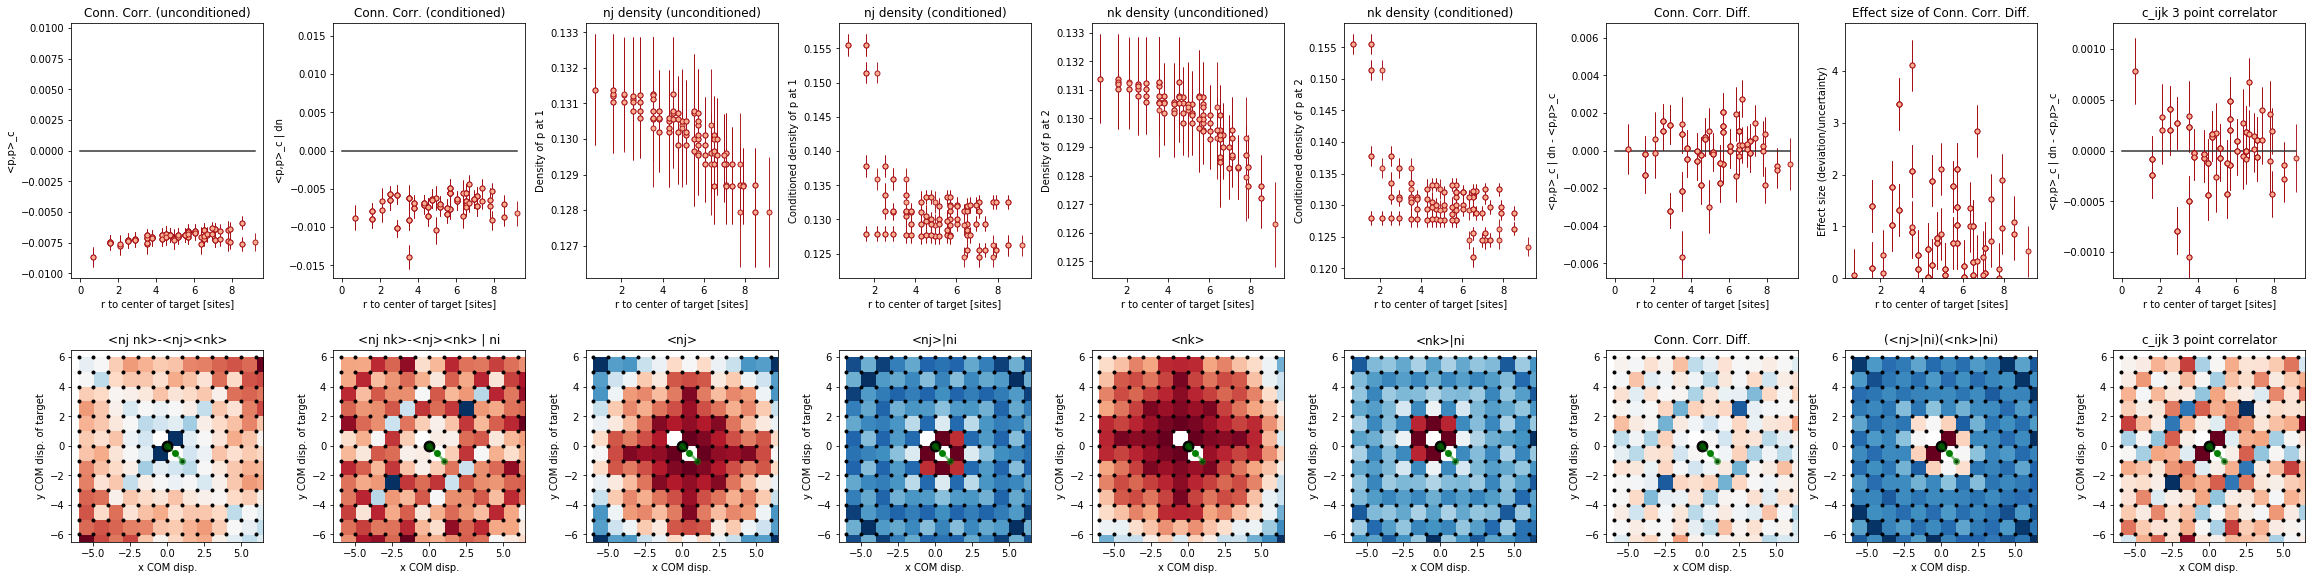

d1to2:  [1, 1]


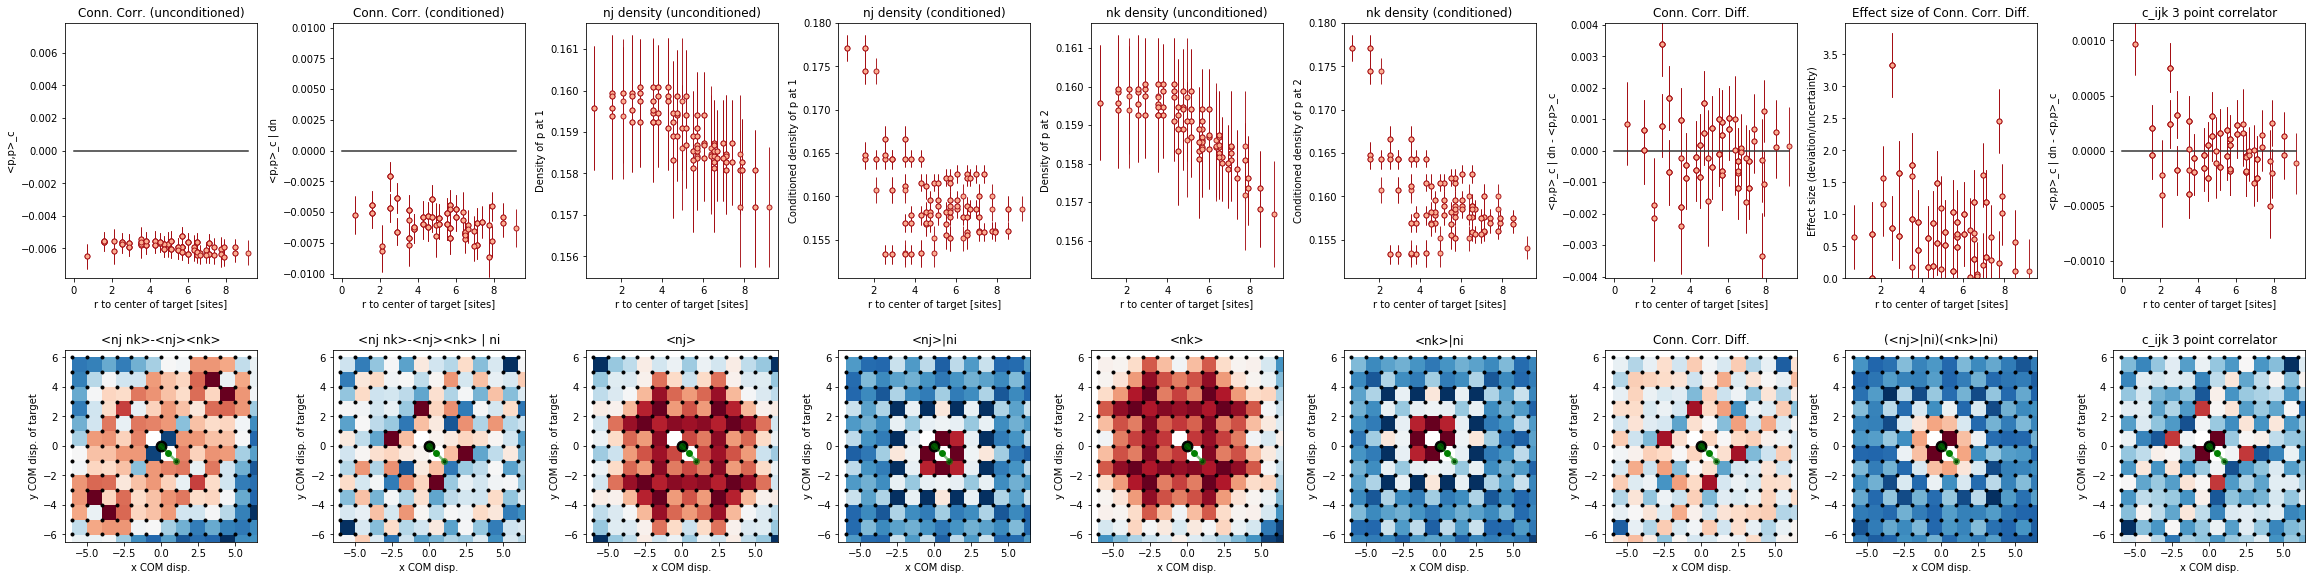

d1to2:  [1, 1]


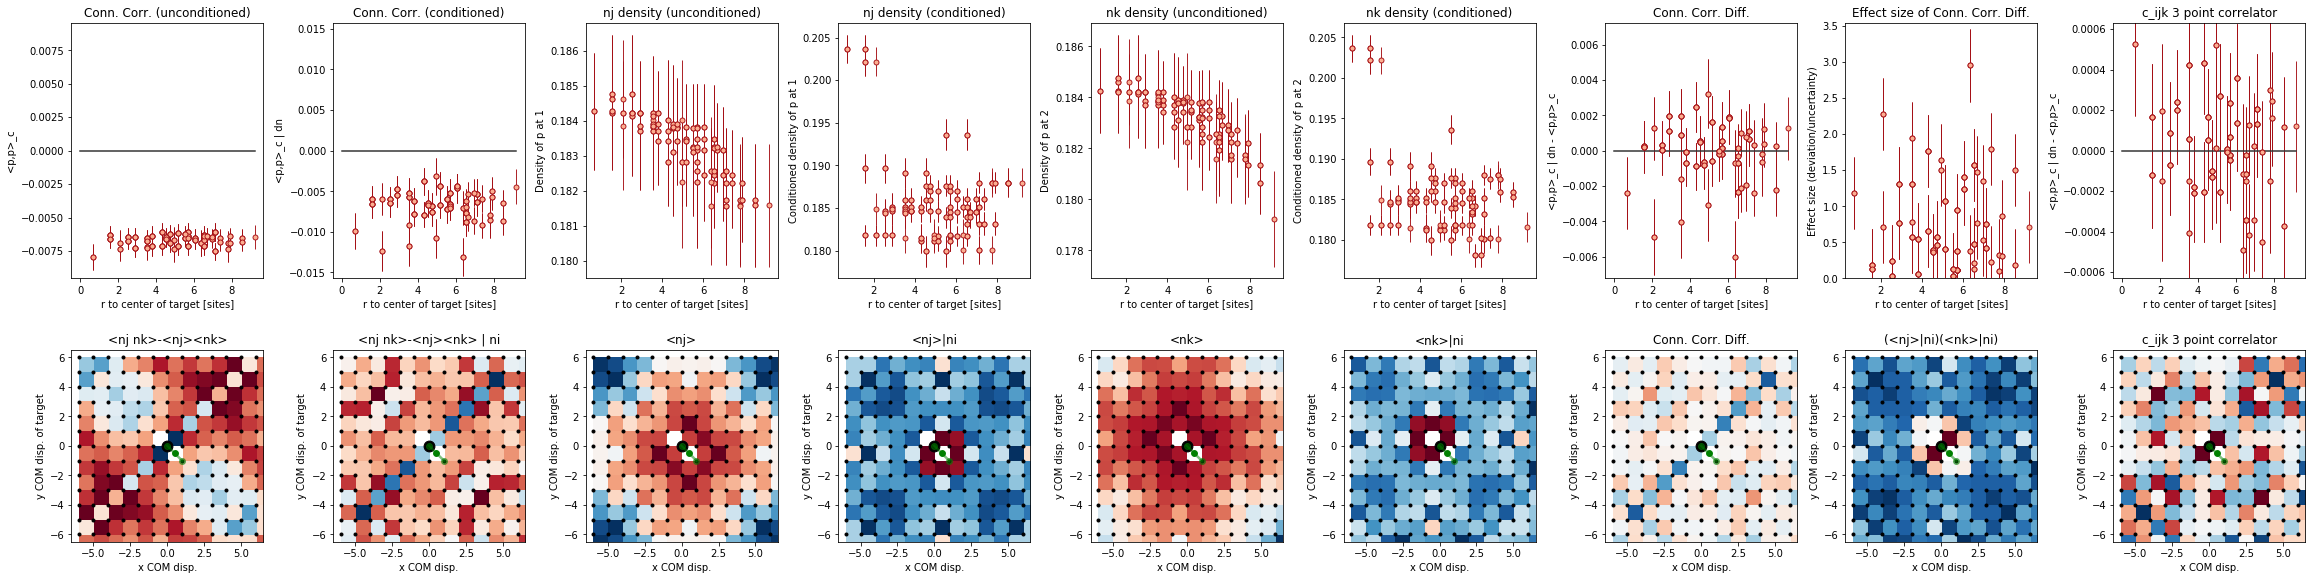

In [91]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 3
key = ['dn','p','p']
d1to2ToDo =[1,1]

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen3PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), d1to2ToDo)

d1to2:  [2, 0]


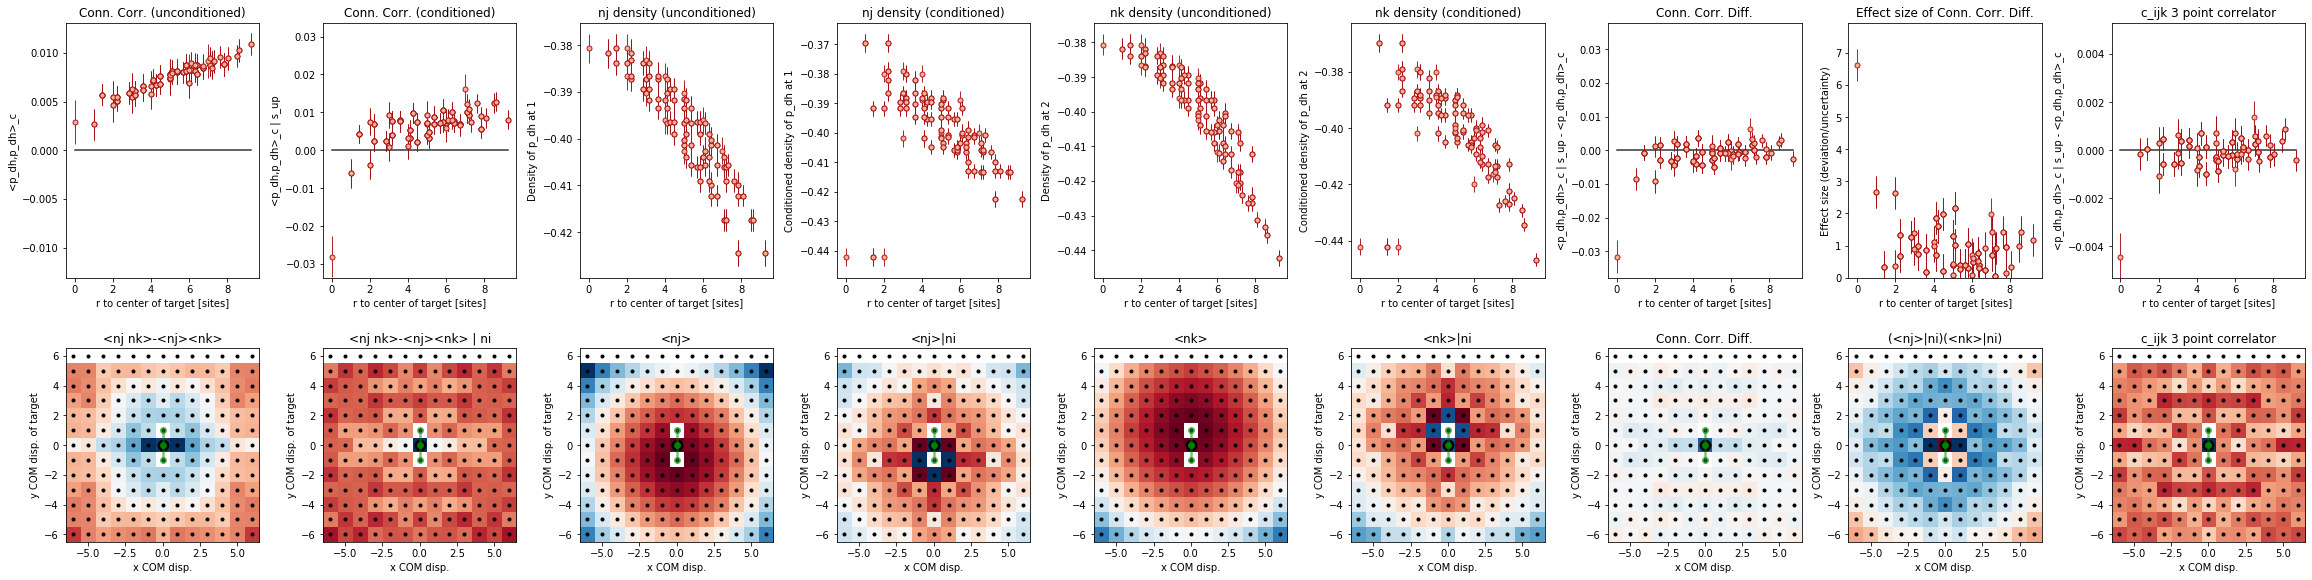

d1to2:  [2, 0]


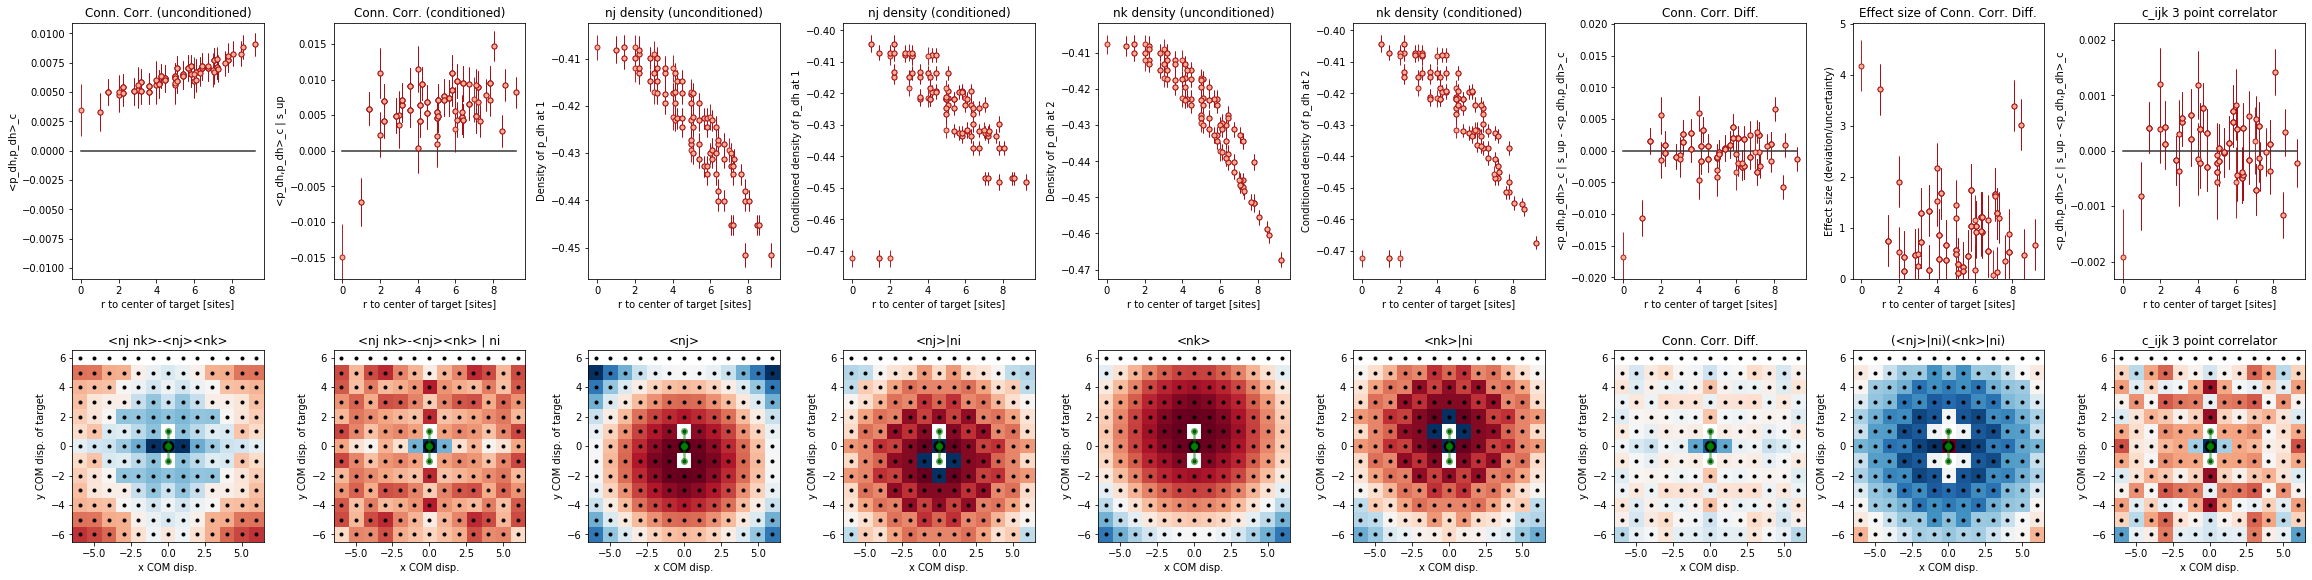

d1to2:  [2, 0]


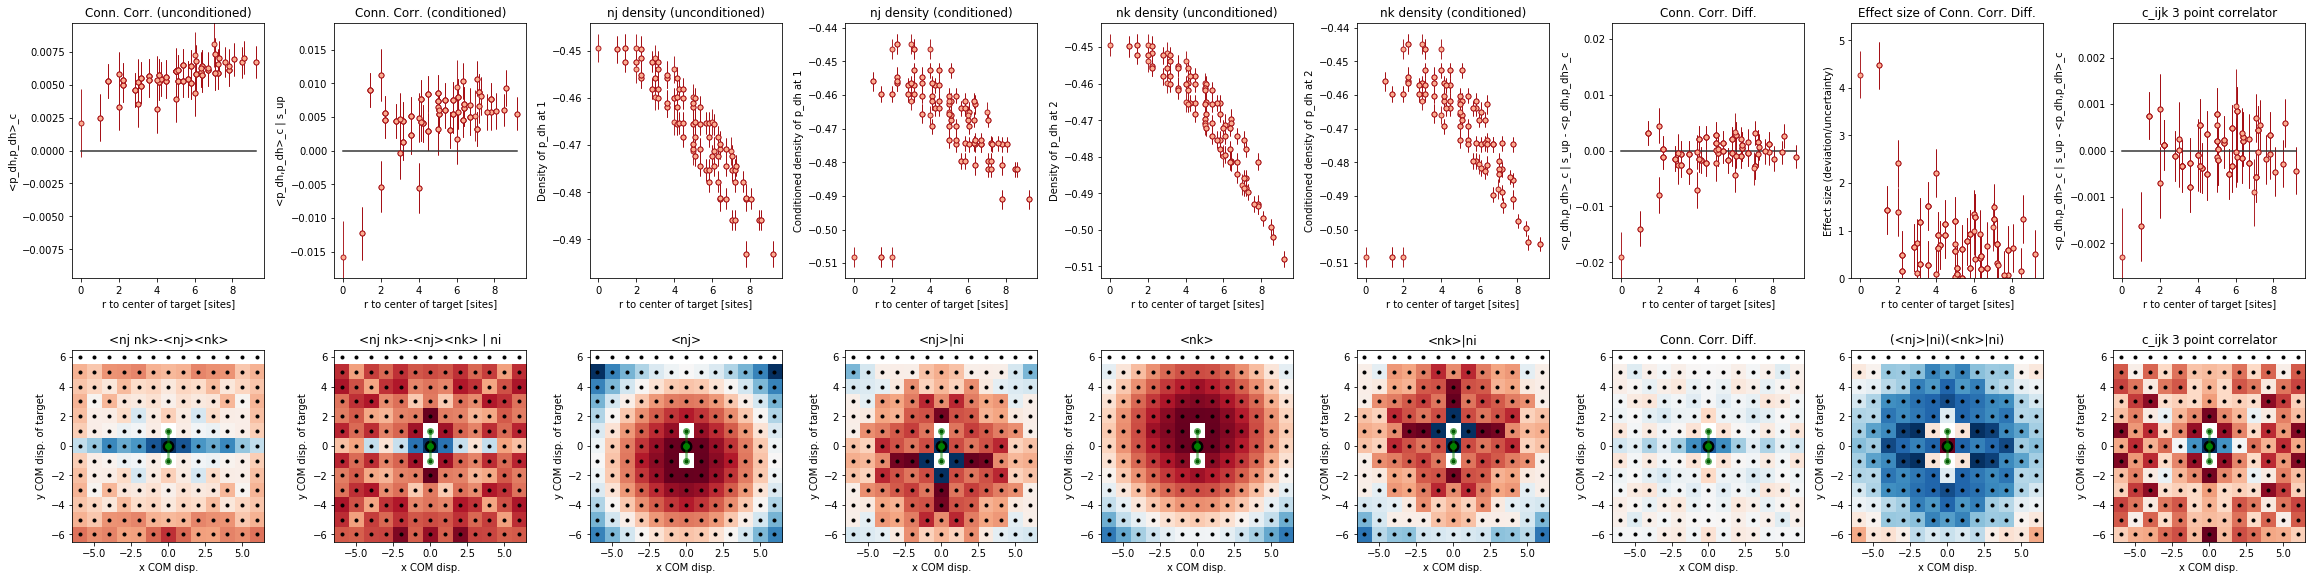

In [81]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 3
key = ['s_up','p_dh','p_dh']
d1to2ToDo =[2,0]

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen3PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), d1to2ToDo)

d1to2:  [2, 0]


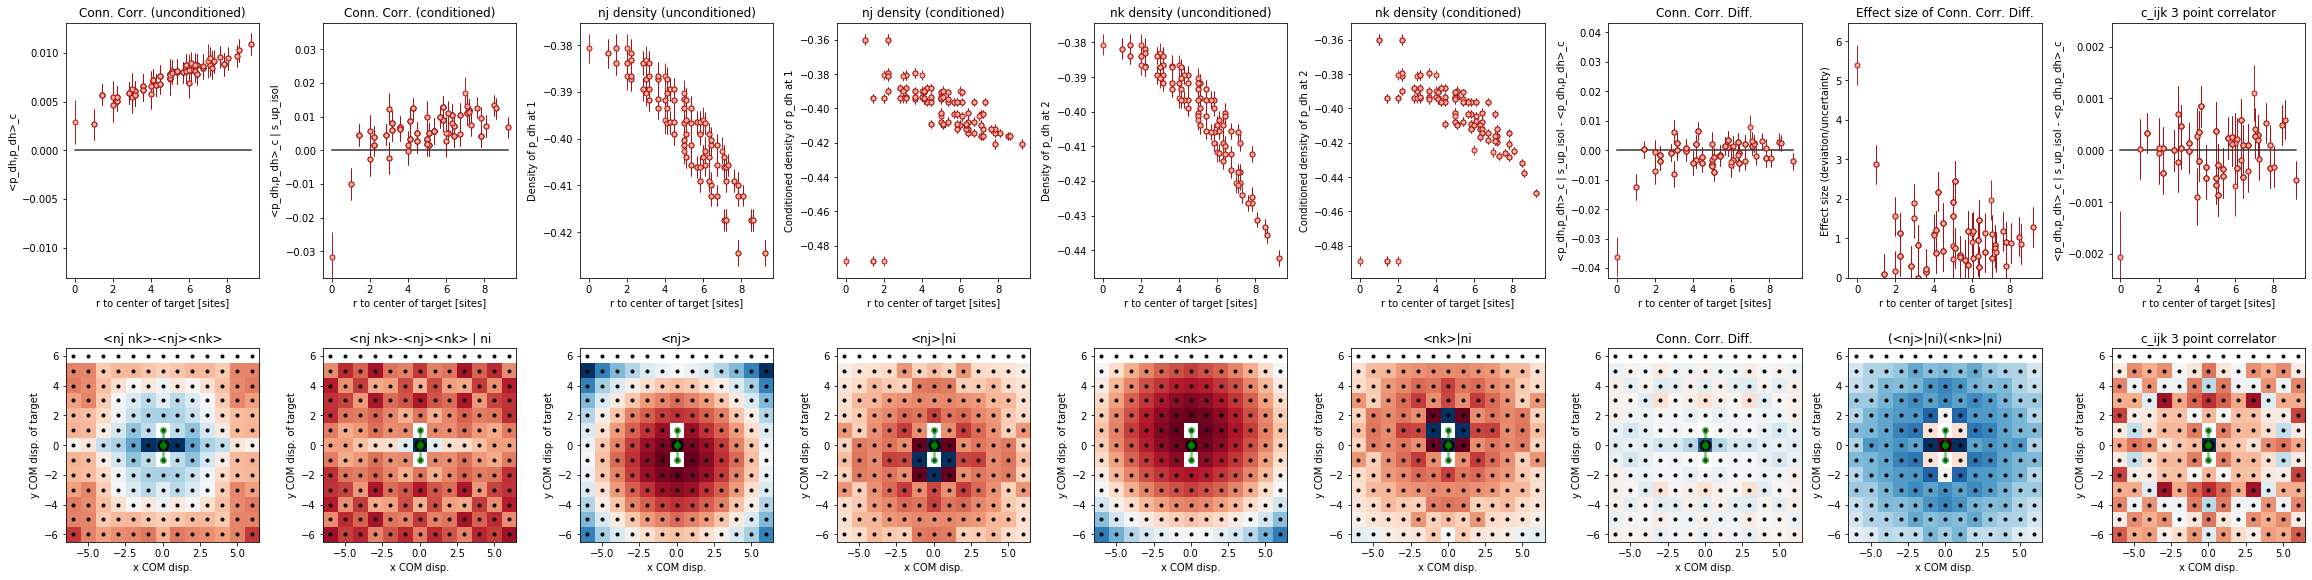

d1to2:  [2, 0]


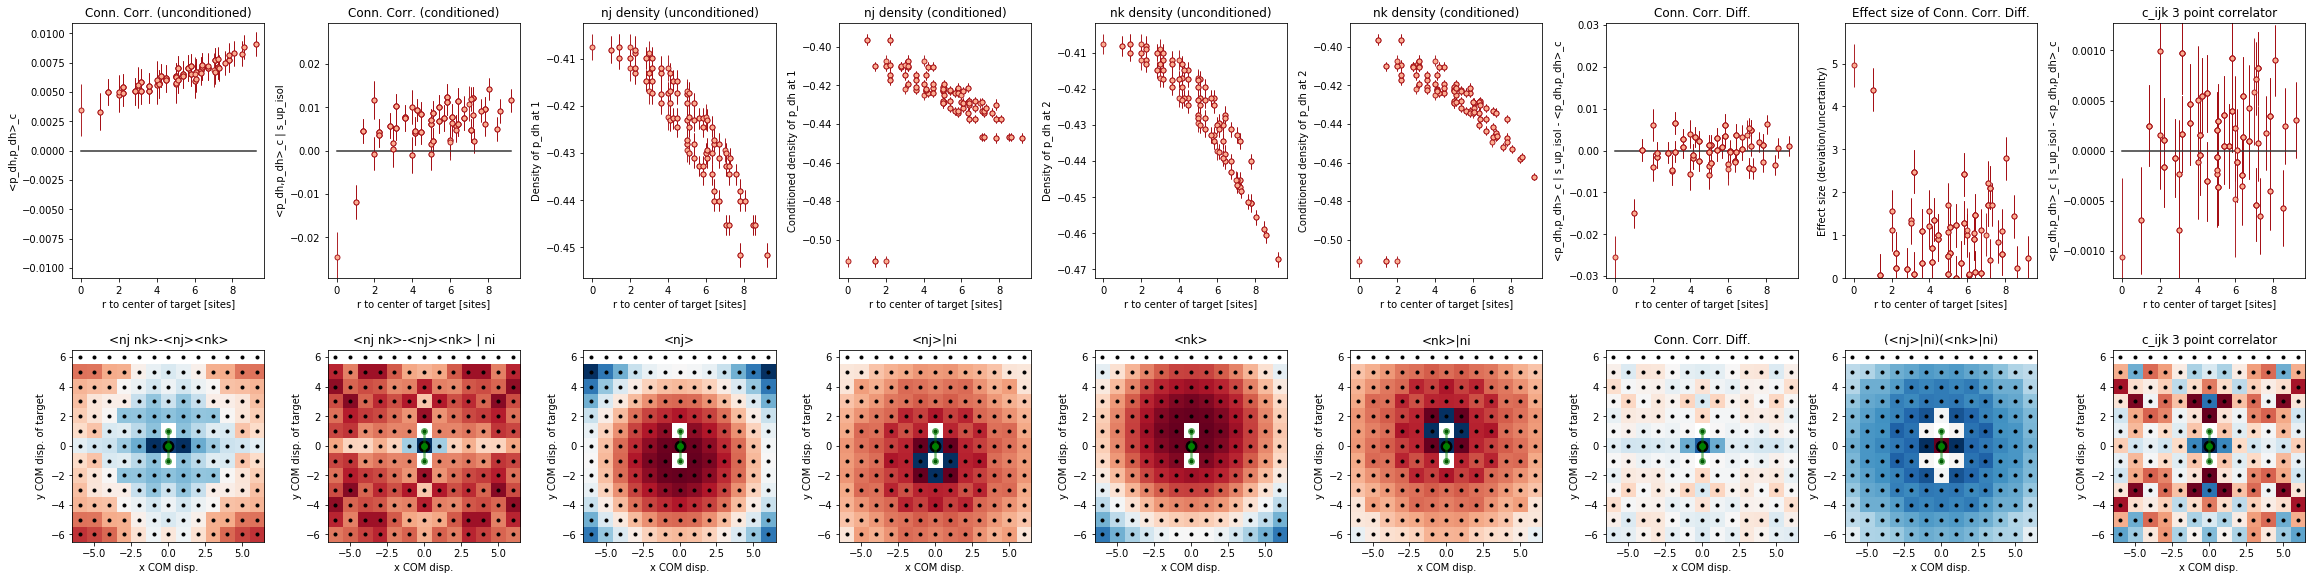

d1to2:  [2, 0]


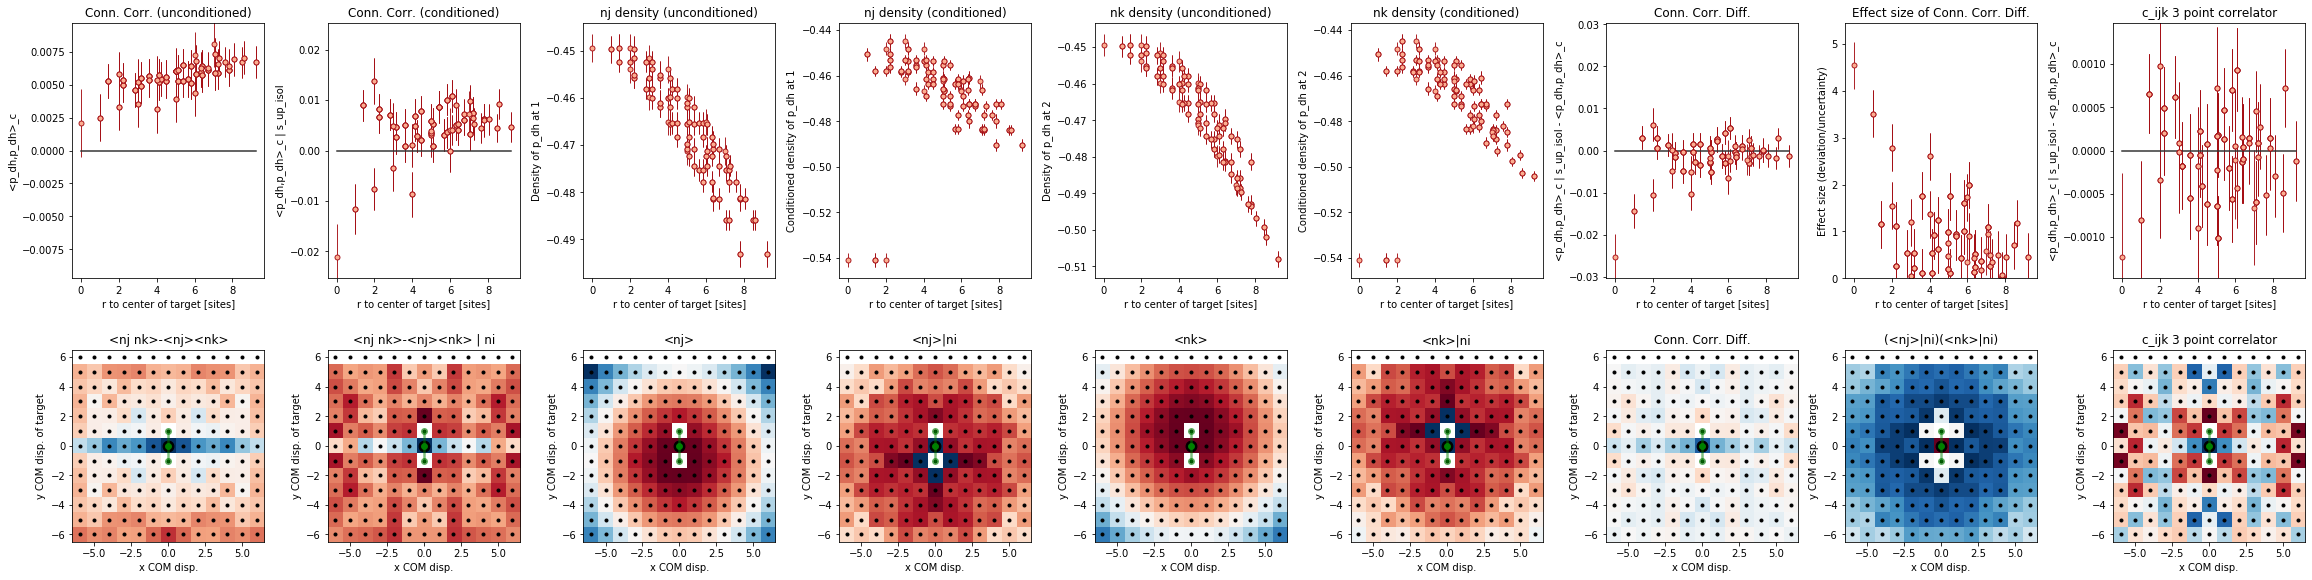

In [93]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 3
key = ['s_up_isol','p_dh','p_dh']
d1to2ToDo =[2,0]

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen3PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), d1to2ToDo)

d1to2:  [2, 0]


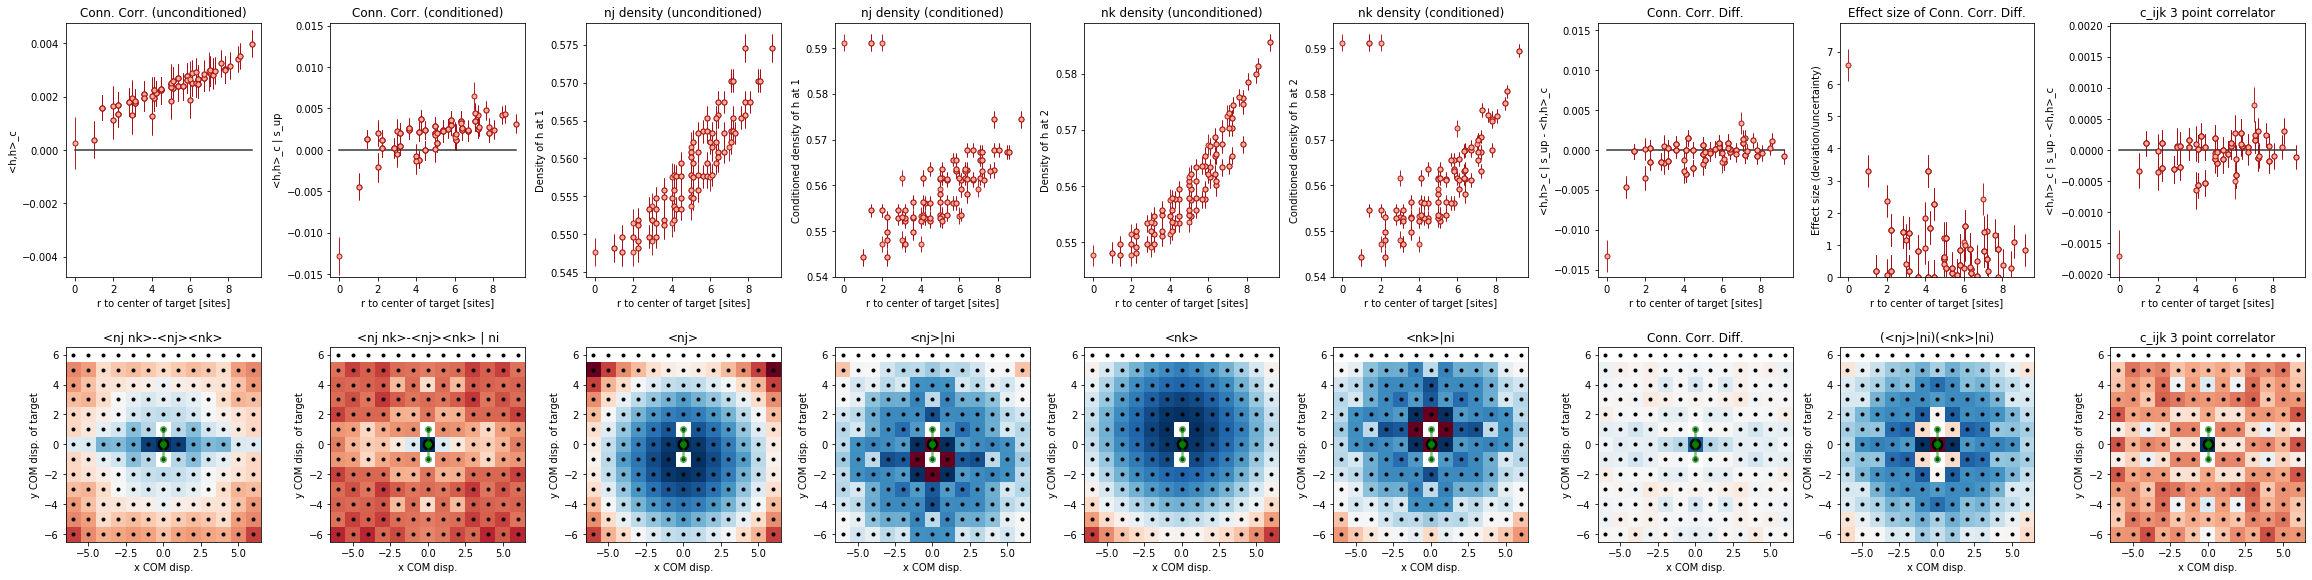

d1to2:  [2, 0]


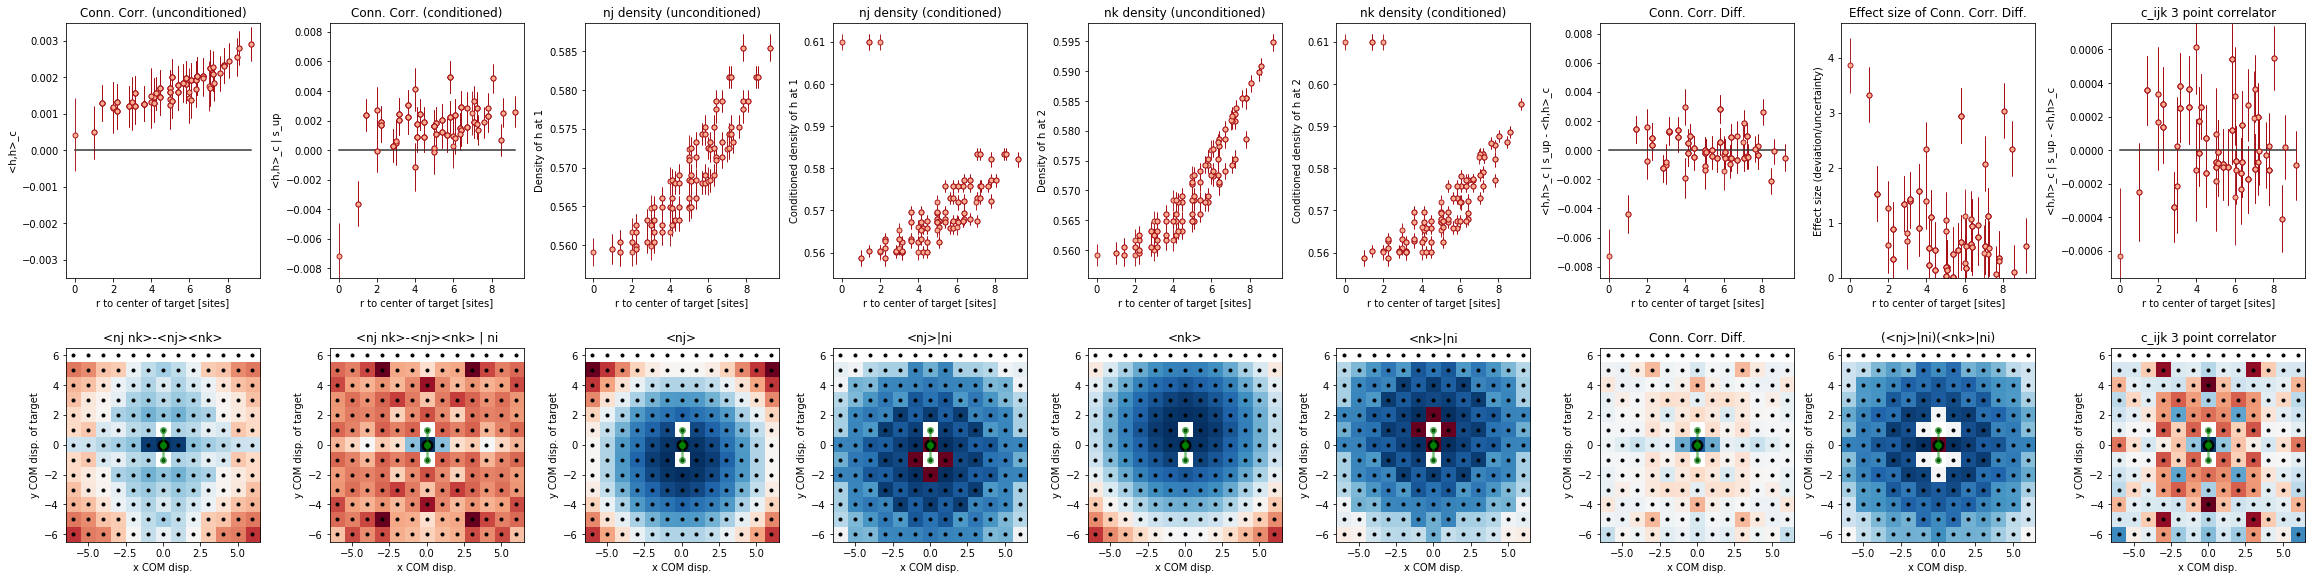

d1to2:  [2, 0]


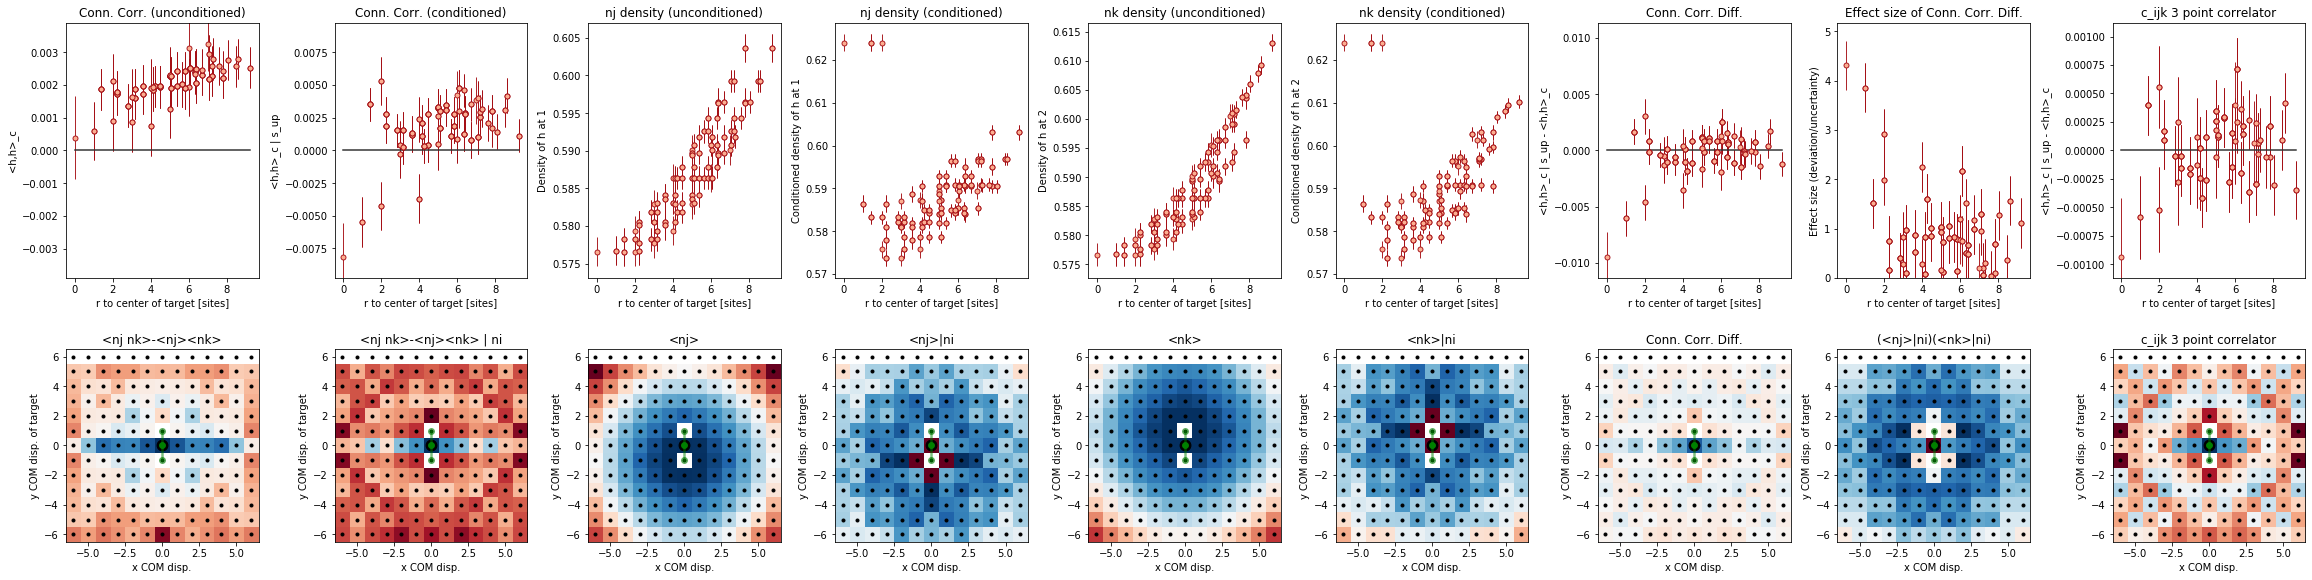

In [92]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 3
key = ['s_up','h','h']
d1to2ToDo =[2,0]

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen3PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), d1to2ToDo)

d1to2:  [2, 0]


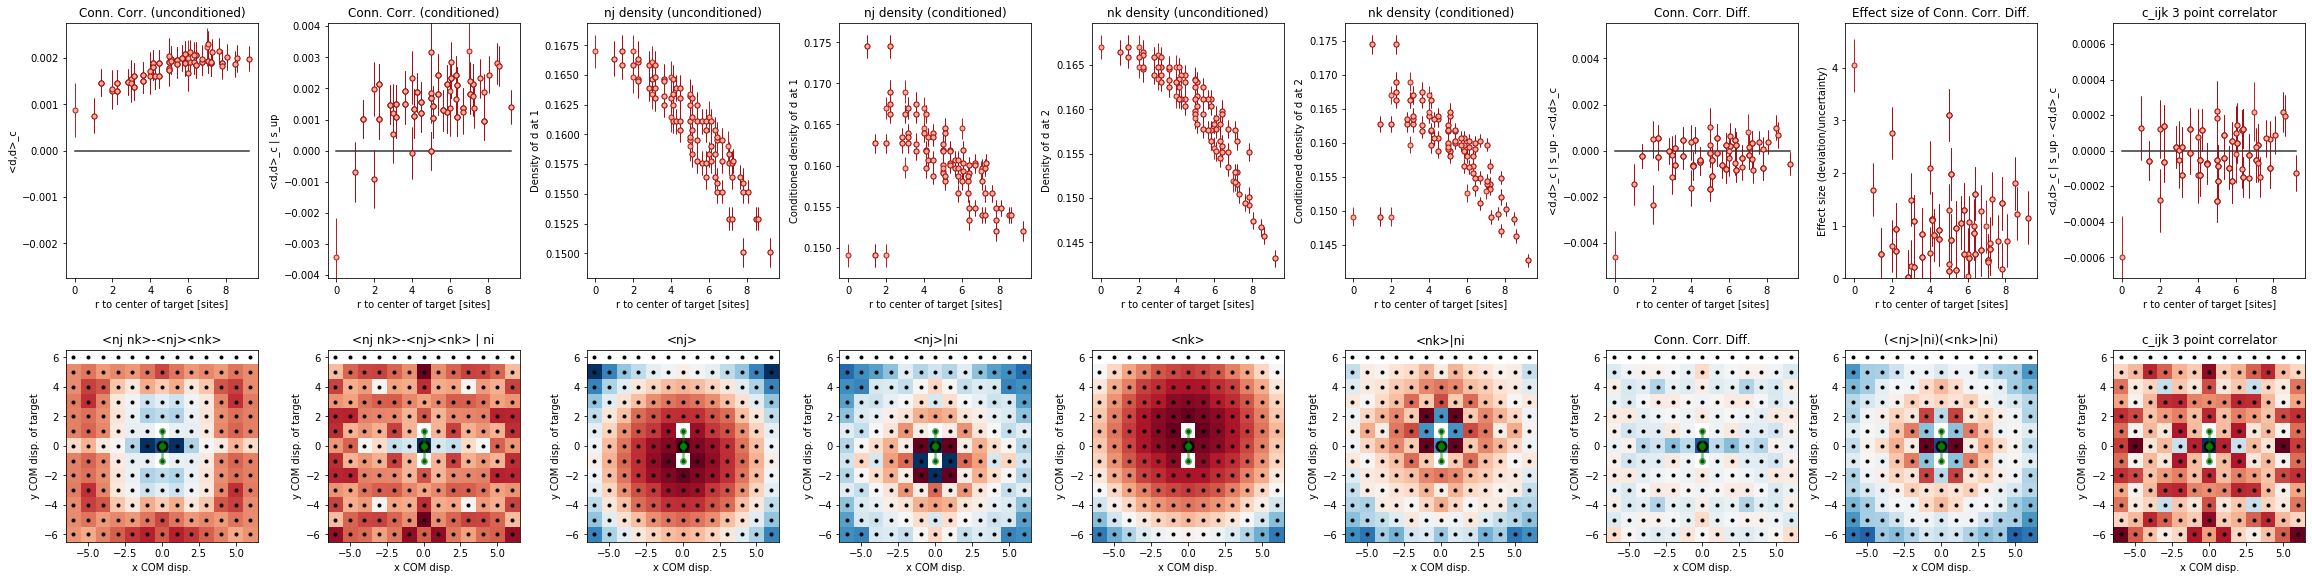

d1to2:  [2, 0]


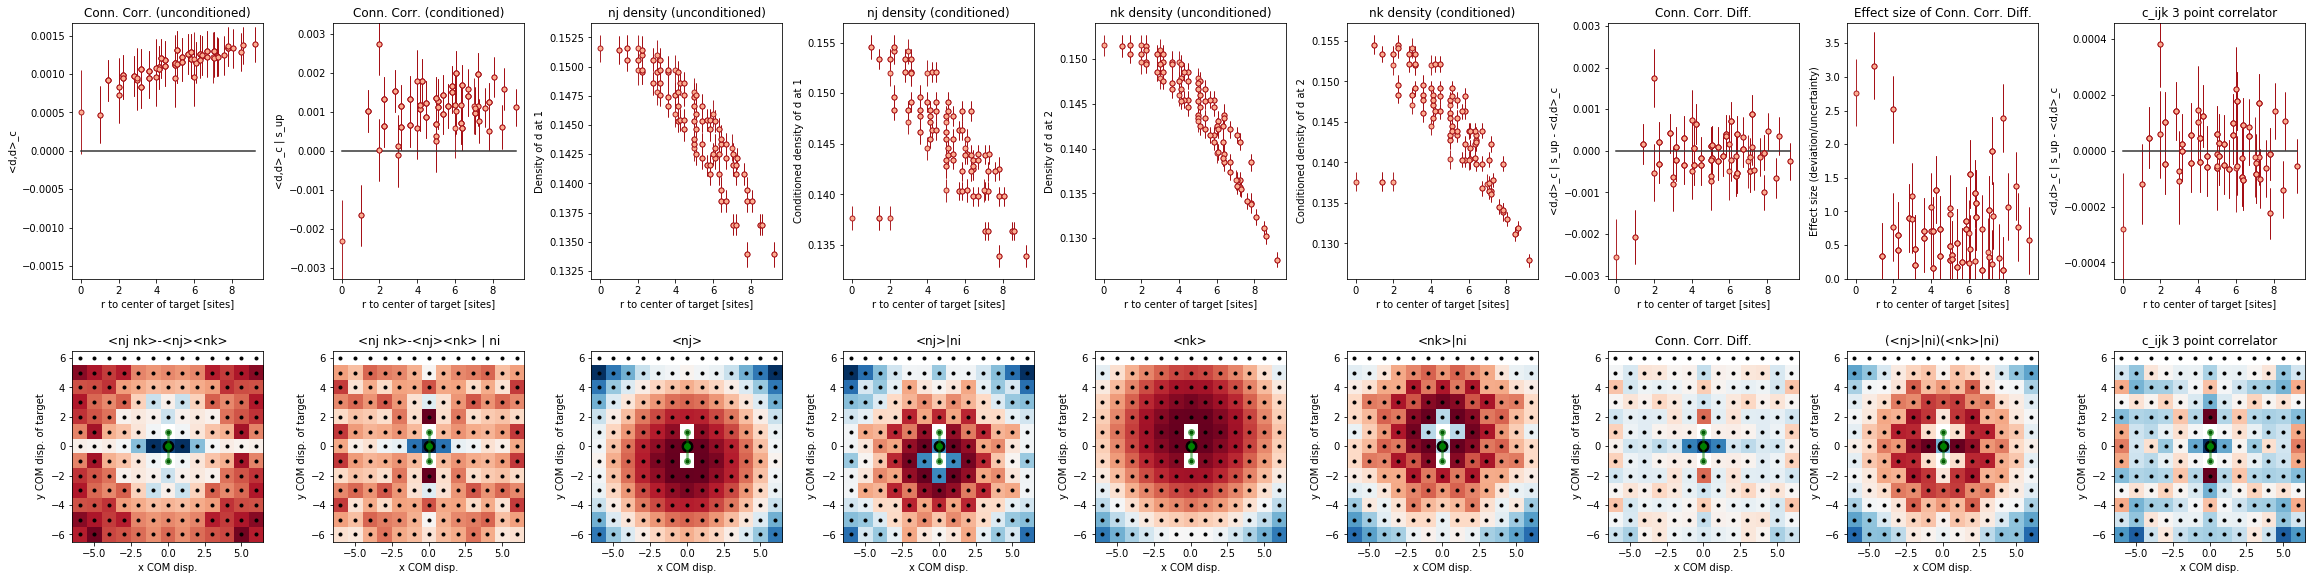

d1to2:  [2, 0]


In [94]:
# Generate plots vs imbalance for a given datatset 
pMin=0.2
pMax=0.5
Np = 3
key = ['s_up','d','d']
d1to2ToDo =[2,0]

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen3PointCorrPlots(key,selectImgs(imgs, _df, 'imbal_corr', pRange), d1to2ToDo)

In [59]:
# Generate many displacement plots for d1to2. TAKES A LONG TIME
if False:
    def genAll3PointCorrPlots(key,imgs, d1to2maxDist):
        print(key)
        for ii in range(1,d1to2maxDist+1):
            for jj in range(ii+1):
                print(key)
                gen3PointCorrPlots(key,imgs,[ii,jj])

    key = ['s_up_isol','p_dh','p_dh']
    genAll3PointCorrPlots(key, imgs, 4)

## Explore FFT

In [22]:
# cent =32
# radBox = 10
# arr = imgs['s_up_isol']
# remove0 = True
# fftArr = np.ones((len(arr),2*radBox , 2*radBox))
# for ii in range(len(arr)):
#     testimg = arr[ii]
#     testimgcut = testimg[cent - radBox: cent+radBox,cent - radBox: cent+radBox]
#     testimgcutFFT = np.abs(np.fft.fft2(testimgcut))**2
#     if remove0:
#         testimgcutFFT[0,0]= 0
#     fftArr[ii]=testimgcutFFT

# fftAvg = np.average(fftArr, axis=0)
# fftAvgCentered= scipy.ndimage.shift(fftAvg, (radBox, radBox), mode = 'wrap')

# plt.imshow(fftAvg)
# plt.show()
# plt.plot(np.average(fftAvg, axis = 0))
# plt.show()